# Training


In [ ]:
import numpy as np
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras import activations
from tensorflow.keras.activations import *
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.layers import Lambda

from transformers import TFAutoModel
from keras.models import Model
from keras.layers import Input, Bidirectional, GRU, Flatten, Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import numpy as np
from google.colab import drive
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

In [ ]:
import os

# Force TensorFlow to use CPU (disable GPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disables the GPU

In [ ]:
from tqdm import tqdm
import numpy as np
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embeddings_path = '/content/drive/MyDrive/A/A_forSkripsiii/BERTembeddings200.npy'

In [ ]:
embedding_array = np.load(embeddings_path)

In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/A/A_forSkripsiii/train.csv')

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class SquashActivation(layers.Layer):
    def call(self, inputs):
        s_squared_norm = tf.reduce_sum(tf.square(inputs), axis=-1, keepdims=True) + tf.keras.backend.epsilon()
        scale = tf.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
        return scale * inputs

    def get_config(self):
        return super().get_config()


In [ ]:
class Capsule(layers.Layer):
    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 initializer='glorot_uniform',
                 activation=None,
                 regularizer=None,
                 constraint=None,
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights

        self.activation = activations.get(activation)
        self.regularizer = regularizers.get(regularizer)
        self.initializer = initializers.get(initializer)
        self.constraint = constraints.get(constraint)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)

        self.build = True

    def call(self, inputs):
        if self.share_weights:
            u_hat_vectors = K.conv1d(inputs, self.W)
        else:
            u_hat_vectors = K.local_conv1d(inputs, self.W, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        u_hat_vectors = K.reshape(u_hat_vectors, (batch_size,
                                                  input_num_capsule,
                                                  self.num_capsule,
                                                  self.dim_capsule))

        u_hat_vectors = K.permute_dimensions(u_hat_vectors, (0, 2, 1, 3))
        routing_weights = K.zeros_like(u_hat_vectors[:, :, :, 0])

        for i in range(self.routings):
            capsule_weights = K.softmax(routing_weights, 1)
            outputs = K.batch_dot(capsule_weights, u_hat_vectors, [2, 2])
            if K.ndim(outputs) == 4:
                outputs = K.sum(outputs, axis=1)
            if i < self.routings - 1:
                outputs = K.l2_normalize(outputs, -1)
                routing_weights = K.batch_dot(outputs, u_hat_vectors, [2, 3])
                if K.ndim(routing_weights) == 4:
                    routing_weights = K.sum(routing_weights, axis=1)

        return self.activation(outputs)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

    def get_config(self):
        config = super(Capsule, self).get_config()
        config.update({
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings,
            'share_weights': self.share_weights,
            'activation': activations.serialize(self.activation),
            'initializer': initializers.serialize(self.initializer),
            'regularizer': regularizers.serialize(self.regularizer),
            'constraint': constraints.serialize(self.constraint)
        })
        return config


In [ ]:
dims = [4, 8, 16, 32, 64]
routings = [3, 4, 5, 6, 7]
capsule_configs = [(d, r) for d in dims for r in routings]

model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN'

In [ ]:
capsule_configs

[(4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (16, 3),
 (16, 4),
 (16, 5),
 (16, 6),
 (16, 7),
 (32, 3),
 (32, 4),
 (32, 5),
 (32, 6),
 (32, 7),
 (64, 3),
 (64, 4),
 (64, 5),
 (64, 6),
 (64, 7)]

In [ ]:
# Prepare labels (multilabel classification)
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(embedding_array, labels, test_size=0.3, random_state=42)
epochs = 10

In [ ]:

for dim_capsule, routings in capsule_configs:
    print(f"\nTraining for dim_capsule={dim_capsule}, routings={routings}...")

    # Create a new checkpoint callback per config
    checkpoint_cb = ModelCheckpoint(
        filepath=os.path.join(model_dir, f'model_dim{dim_capsule}_routing{routings}_epoch{{epoch:02d}}.h5'),
        save_weights_only=False,
        save_best_only=False,
        verbose=1
    )

    model = Sequential([
        Bidirectional(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1))),
        Capsule(num_capsule=6, dim_capsule=dim_capsule, routings=routings, activation=SquashActivation()),
        Flatten(),
        Dense(6, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy']
    )

    model.build((None, X_train.shape[1], 1))
    print(model.summary())

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=128,
        epochs=epochs,
        verbose=1,
        callbacks=[checkpoint_cb]
    )


Training for dim_capsule=4, routings=3...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule (Capsule)               │ (None, 6, 4)           │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,950 (113.09 KB)

 Trainable params: 28,950 (113.09 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4921 - loss: 0.2080
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 70ms/step - accuracy: 0.4925 - loss: 0.2079 - val_accuracy: 0.9940 - val_loss: 0.1398
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9940 - loss: 0.1330
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9940 - loss: 0.1330 - val_accuracy: 0.9940 - val_loss: 0.1054
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9937 - loss: 0.0951
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9937 - loss: 0.0951 - val_accuracy: 0.9940 - val_loss: 0.0848
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9945 - loss: 0.0858
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9945 - loss: 0.0858 - val_accuracy: 0.9940 - val_loss: 0.0865
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9939 - loss: 0.0810
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9939 - loss: 0.0810 - val_accuracy: 0.9940 - val_loss: 0.0776
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9939 - loss: 0.0798
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9939 - loss: 0.0798 - val_accuracy: 0.9940 - val_loss: 0.0777
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9941 - loss: 0.0771
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9941 - loss: 0.0771 - val_accuracy: 0.9935 - val_loss: 0.0745
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9939 - loss: 0.0749
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9939 - loss: 0.0749 - val_accuracy: 0.9909 - val_loss: 0.0776
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9941 - loss: 0.0741
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9941 - loss: 0.0741 - val_accuracy: 0.9939 - val_loss: 0.0732
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9937 - loss: 0.0725
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing3_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9937 - loss: 0.0725 - val_accuracy: 0.9939 - val_loss: 0.0748

Training for dim_capsule=4, routings=4...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_1 (Capsule)             │ (None, 6, 4)           │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,950 (113.09 KB)

 Trainable params: 28,950 (113.09 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5275 - loss: 0.1987
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.5278 - loss: 0.1987 - val_accuracy: 0.9940 - val_loss: 0.1418
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9938 - loss: 0.1396
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9938 - loss: 0.1396 - val_accuracy: 0.9940 - val_loss: 0.1308
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9942 - loss: 0.1277
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9942 - loss: 0.1277 - val_accuracy: 0.9940 - val_loss: 0.1082
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9939 - loss: 0.1039
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9939 - loss: 0.1039 - val_accuracy: 0.9940 - val_loss: 0.0917
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9942 - loss: 0.0885
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9942 - loss: 0.0885 - val_accuracy: 0.9940 - val_loss: 0.0868
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9941 - loss: 0.0831
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9941 - loss: 0.0831 - val_accuracy: 0.9940 - val_loss: 0.0807
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9945 - loss: 0.0799
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9945 - loss: 0.0799 - val_accuracy: 0.9940 - val_loss: 0.0783
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9940 - loss: 0.0784
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9940 - loss: 0.0784 - val_accuracy: 0.9940 - val_loss: 0.0763
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9939 - loss: 0.0767
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9939 - loss: 0.0767 - val_accuracy: 0.9940 - val_loss: 0.0807
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9939 - loss: 0.0754
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing4_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9939 - loss: 0.0754 - val_accuracy: 0.9940 - val_loss: 0.0781

Training for dim_capsule=4, routings=5...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_2 (Capsule)             │ (None, 6, 4)           │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,950 (113.09 KB)

 Trainable params: 28,950 (113.09 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5402 - loss: 0.2149
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 70ms/step - accuracy: 0.5406 - loss: 0.2148 - val_accuracy: 0.9940 - val_loss: 0.1416
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9932 - loss: 0.1361
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9932 - loss: 0.1361 - val_accuracy: 0.9940 - val_loss: 0.1076
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9942 - loss: 0.1045
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9942 - loss: 0.1045 - val_accuracy: 0.9940 - val_loss: 0.0951
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9939 - loss: 0.0928
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9939 - loss: 0.0928 - val_accuracy: 0.9940 - val_loss: 0.0852
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9941 - loss: 0.0864
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9941 - loss: 0.0864 - val_accuracy: 0.9940 - val_loss: 0.0831
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9942 - loss: 0.0826
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9942 - loss: 0.0826 - val_accuracy: 0.9940 - val_loss: 0.0802
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9944 - loss: 0.0799
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9944 - loss: 0.0799 - val_accuracy: 0.9940 - val_loss: 0.0806
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9936 - loss: 0.0788
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9936 - loss: 0.0788 - val_accuracy: 0.9924 - val_loss: 0.0781
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9929 - loss: 0.0777
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9929 - loss: 0.0777 - val_accuracy: 0.9870 - val_loss: 0.0800
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9919 - loss: 0.0750
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing5_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9919 - loss: 0.0750 - val_accuracy: 0.9929 - val_loss: 0.0750

Training for dim_capsule=4, routings=6...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_3 (Capsule)             │ (None, 6, 4)           │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,950 (113.09 KB)

 Trainable params: 28,950 (113.09 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5140 - loss: 0.1912
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 65s 70ms/step - accuracy: 0.5143 - loss: 0.1912 - val_accuracy: 0.9940 - val_loss: 0.1421
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9935 - loss: 0.1397
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9935 - loss: 0.1397 - val_accuracy: 0.9940 - val_loss: 0.1206
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9901 - loss: 0.1148
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9901 - loss: 0.1148 - val_accuracy: 0.9940 - val_loss: 0.1027
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9938 - loss: 0.1002
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9938 - loss: 0.1002 - val_accuracy: 0.9940 - val_loss: 0.0969
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9942 - loss: 0.0899
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9942 - loss: 0.0899 - val_accuracy: 0.9940 - val_loss: 0.0936
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9944 - loss: 0.0849
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9944 - loss: 0.0849 - val_accuracy: 0.9940 - val_loss: 0.0814
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9944 - loss: 0.0814
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9944 - loss: 0.0814 - val_accuracy: 0.9940 - val_loss: 0.0819
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9943 - loss: 0.0804
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9943 - loss: 0.0804 - val_accuracy: 0.9940 - val_loss: 0.0786
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9935 - loss: 0.0782
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9935 - loss: 0.0782 - val_accuracy: 0.9936 - val_loss: 0.0771
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9931 - loss: 0.0786
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing6_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9931 - loss: 0.0786 - val_accuracy: 0.9940 - val_loss: 0.0780

Training for dim_capsule=4, routings=7...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_4 (Capsule)             │ (None, 6, 4)           │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,950 (113.09 KB)

 Trainable params: 28,950 (113.09 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9859 - loss: 0.2159
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 66s 71ms/step - accuracy: 0.9859 - loss: 0.2158 - val_accuracy: 0.9940 - val_loss: 0.1425
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9941 - loss: 0.1338
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9941 - loss: 0.1338 - val_accuracy: 0.9940 - val_loss: 0.1139
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9946 - loss: 0.1033
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9946 - loss: 0.1033 - val_accuracy: 0.9940 - val_loss: 0.1022
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9945 - loss: 0.0933
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9945 - loss: 0.0933 - val_accuracy: 0.9940 - val_loss: 0.0894
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9942 - loss: 0.0875
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9942 - loss: 0.0875 - val_accuracy: 0.9940 - val_loss: 0.0839
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9945 - loss: 0.0827
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9945 - loss: 0.0827 - val_accuracy: 0.9940 - val_loss: 0.0845
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9943 - loss: 0.0817
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9943 - loss: 0.0817 - val_accuracy: 0.9940 - val_loss: 0.0802
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9944 - loss: 0.0795
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9944 - loss: 0.0795 - val_accuracy: 0.9940 - val_loss: 0.0801
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9943 - loss: 0.0783
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9943 - loss: 0.0783 - val_accuracy: 0.9940 - val_loss: 0.0759
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9942 - loss: 0.0757
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim4_routing7_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9942 - loss: 0.0757 - val_accuracy: 0.9940 - val_loss: 0.0785

Training for dim_capsule=8, routings=3...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_5 (Capsule)             │ (None, 6, 8)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,166 (125.65 KB)

 Trainable params: 32,166 (125.65 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7545 - loss: 0.1821
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.7547 - loss: 0.1821 - val_accuracy: 0.9940 - val_loss: 0.1408
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9941 - loss: 0.1341
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9941 - loss: 0.1341 - val_accuracy: 0.9940 - val_loss: 0.1047
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9945 - loss: 0.0984
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9945 - loss: 0.0984 - val_accuracy: 0.9940 - val_loss: 0.0936
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9941 - loss: 0.0902
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9941 - loss: 0.0902 - val_accuracy: 0.9940 - val_loss: 0.0859
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9939 - loss: 0.0852
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9939 - loss: 0.0852 - val_accuracy: 0.9940 - val_loss: 0.0834
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9944 - loss: 0.0808
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9944 - loss: 0.0808 - val_accuracy: 0.9940 - val_loss: 0.0815
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9944 - loss: 0.0787
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9944 - loss: 0.0787 - val_accuracy: 0.9940 - val_loss: 0.0786
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9945 - loss: 0.0784
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9945 - loss: 0.0784 - val_accuracy: 0.9940 - val_loss: 0.0765
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9939 - loss: 0.0760
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9939 - loss: 0.0760 - val_accuracy: 0.9940 - val_loss: 0.0769
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9943 - loss: 0.0748
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9943 - loss: 0.0748 - val_accuracy: 0.9940 - val_loss: 0.0750

Training for dim_capsule=8, routings=4...


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_6 (Capsule)             │ (None, 6, 8)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,166 (125.65 KB)

 Trainable params: 32,166 (125.65 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7423 - loss: 0.1869
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 65s 70ms/step - accuracy: 0.7426 - loss: 0.1869 - val_accuracy: 0.9940 - val_loss: 0.1411
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9943 - loss: 0.1335
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9943 - loss: 0.1335 - val_accuracy: 0.9940 - val_loss: 0.1025
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9940 - loss: 0.0973
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9940 - loss: 0.0973 - val_accuracy: 0.9940 - val_loss: 0.0917
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9945 - loss: 0.0903
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9945 - loss: 0.0903 - val_accuracy: 0.9940 - val_loss: 0.0873
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9943 - loss: 0.0854
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9943 - loss: 0.0854 - val_accuracy: 0.9940 - val_loss: 0.0837
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9939 - loss: 0.0849
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9939 - loss: 0.0849 - val_accuracy: 0.9940 - val_loss: 0.0803
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9944 - loss: 0.0799
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9944 - loss: 0.0799 - val_accuracy: 0.9940 - val_loss: 0.0791
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9939 - loss: 0.0795
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9939 - loss: 0.0795 - val_accuracy: 0.9940 - val_loss: 0.0754
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9939 - loss: 0.0762
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9939 - loss: 0.0762 - val_accuracy: 0.9940 - val_loss: 0.0761
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9941 - loss: 0.0748
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing4_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9941 - loss: 0.0748 - val_accuracy: 0.9940 - val_loss: 0.0755

Training for dim_capsule=8, routings=5...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_7 (Capsule)             │ (None, 6, 8)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,166 (125.65 KB)

 Trainable params: 32,166 (125.65 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9818 - loss: 0.1889
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 65s 70ms/step - accuracy: 0.9818 - loss: 0.1889 - val_accuracy: 0.9940 - val_loss: 0.1370
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9940 - loss: 0.1327
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9940 - loss: 0.1327 - val_accuracy: 0.9940 - val_loss: 0.1124
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9945 - loss: 0.0907
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9945 - loss: 0.0907 - val_accuracy: 0.9940 - val_loss: 0.0888
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9947 - loss: 0.0814
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9947 - loss: 0.0814 - val_accuracy: 0.9940 - val_loss: 0.0797
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9943 - loss: 0.0787
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9943 - loss: 0.0787 - val_accuracy: 0.9939 - val_loss: 0.0773
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9941 - loss: 0.0787
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9941 - loss: 0.0787 - val_accuracy: 0.9940 - val_loss: 0.0801
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9944 - loss: 0.0768
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9944 - loss: 0.0768 - val_accuracy: 0.9939 - val_loss: 0.0756
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9934 - loss: 0.0756
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 69ms/step - accuracy: 0.9934 - loss: 0.0756 - val_accuracy: 0.9935 - val_loss: 0.0764
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9938 - loss: 0.0747
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9938 - loss: 0.0747 - val_accuracy: 0.9927 - val_loss: 0.0736
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9932 - loss: 0.0743
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing5_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9932 - loss: 0.0743 - val_accuracy: 0.9936 - val_loss: 0.0720

Training for dim_capsule=8, routings=6...


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_8 (Capsule)             │ (None, 6, 8)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,166 (125.65 KB)

 Trainable params: 32,166 (125.65 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7221 - loss: 0.1970
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 66s 72ms/step - accuracy: 0.7223 - loss: 0.1970 - val_accuracy: 0.9940 - val_loss: 0.1414
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9940 - loss: 0.1366
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9940 - loss: 0.1366 - val_accuracy: 0.9940 - val_loss: 0.1107
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9940 - loss: 0.1009
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9940 - loss: 0.1009 - val_accuracy: 0.9940 - val_loss: 0.0909
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9943 - loss: 0.0890
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9943 - loss: 0.0890 - val_accuracy: 0.9940 - val_loss: 0.0884
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9942 - loss: 0.0843
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9942 - loss: 0.0843 - val_accuracy: 0.9940 - val_loss: 0.0872
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9941 - loss: 0.0809
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9941 - loss: 0.0809 - val_accuracy: 0.9940 - val_loss: 0.0802
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9936 - loss: 0.0798
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9936 - loss: 0.0798 - val_accuracy: 0.9940 - val_loss: 0.0772
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9940 - loss: 0.0768
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9940 - loss: 0.0768 - val_accuracy: 0.9931 - val_loss: 0.0795
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9937 - loss: 0.0758
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9937 - loss: 0.0758 - val_accuracy: 0.9940 - val_loss: 0.0814
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9935 - loss: 0.0743
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing6_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.9935 - loss: 0.0743 - val_accuracy: 0.9940 - val_loss: 0.0731

Training for dim_capsule=8, routings=7...


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 768, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_9 (Capsule)             │ (None, 6, 8)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,166 (125.65 KB)

 Trainable params: 32,166 (125.65 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7019 - loss: 0.1838
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 73ms/step - accuracy: 0.7021 - loss: 0.1838 - val_accuracy: 0.9940 - val_loss: 0.1409
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9943 - loss: 0.1339
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9943 - loss: 0.1339 - val_accuracy: 0.9940 - val_loss: 0.1090
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9940 - loss: 0.1036
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9940 - loss: 0.1036 - val_accuracy: 0.9940 - val_loss: 0.0941
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9939 - loss: 0.0936
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9939 - loss: 0.0936 - val_accuracy: 0.9940 - val_loss: 0.0929
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9944 - loss: 0.0863
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9944 - loss: 0.0863 - val_accuracy: 0.9940 - val_loss: 0.0835
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9939 - loss: 0.0827
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9939 - loss: 0.0827 - val_accuracy: 0.9940 - val_loss: 0.0800
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9944 - loss: 0.0801
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9944 - loss: 0.0801 - val_accuracy: 0.9940 - val_loss: 0.0785
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9942 - loss: 0.0779
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9942 - loss: 0.0779 - val_accuracy: 0.9940 - val_loss: 0.0770
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9941 - loss: 0.0768
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9941 - loss: 0.0768 - val_accuracy: 0.9940 - val_loss: 0.0767
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9939 - loss: 0.0727
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9939 - loss: 0.0727 - val_accuracy: 0.9940 - val_loss: 0.0729

Training for dim_capsule=16, routings=3...


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_10 (Capsule)            │ (None, 6, 16)          │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,598 (150.77 KB)

 Trainable params: 38,598 (150.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8542 - loss: 0.1777
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 65s 71ms/step - accuracy: 0.8544 - loss: 0.1777 - val_accuracy: 0.9940 - val_loss: 0.1409
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9942 - loss: 0.1264
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9942 - loss: 0.1264 - val_accuracy: 0.9940 - val_loss: 0.1155
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9942 - loss: 0.0993
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9942 - loss: 0.0993 - val_accuracy: 0.9940 - val_loss: 0.0930
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9945 - loss: 0.0921
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9945 - loss: 0.0921 - val_accuracy: 0.9940 - val_loss: 0.0969
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9942 - loss: 0.0872
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9942 - loss: 0.0872 - val_accuracy: 0.9940 - val_loss: 0.0825
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9944 - loss: 0.0829
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9944 - loss: 0.0829 - val_accuracy: 0.9940 - val_loss: 0.0826
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9943 - loss: 0.0797
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9943 - loss: 0.0797 - val_accuracy: 0.9940 - val_loss: 0.0782
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9943 - loss: 0.0792
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9943 - loss: 0.0792 - val_accuracy: 0.9940 - val_loss: 0.0773
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9942 - loss: 0.0762
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9942 - loss: 0.0762 - val_accuracy: 0.9940 - val_loss: 0.0761
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9941 - loss: 0.0753
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing3_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 61s 70ms/step - accuracy: 0.9941 - loss: 0.0753 - val_accuracy: 0.9940 - val_loss: 0.0776

Training for dim_capsule=16, routings=4...


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_11                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_11 (Capsule)            │ (None, 6, 16)          │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,598 (150.77 KB)

 Trainable params: 38,598 (150.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9854 - loss: 0.1803
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 67s 73ms/step - accuracy: 0.9854 - loss: 0.1802 - val_accuracy: 0.9940 - val_loss: 0.1405
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9942 - loss: 0.1315
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9942 - loss: 0.1315 - val_accuracy: 0.9940 - val_loss: 0.1009
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9945 - loss: 0.0971
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9945 - loss: 0.0971 - val_accuracy: 0.9940 - val_loss: 0.0930
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9940 - loss: 0.0905
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9940 - loss: 0.0905 - val_accuracy: 0.9940 - val_loss: 0.0861
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9943 - loss: 0.0854
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9943 - loss: 0.0854 - val_accuracy: 0.9940 - val_loss: 0.0825
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9940 - loss: 0.0833
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9940 - loss: 0.0833 - val_accuracy: 0.9940 - val_loss: 0.0799
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9941 - loss: 0.0802
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9941 - loss: 0.0802 - val_accuracy: 0.9940 - val_loss: 0.0778
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9941 - loss: 0.0773
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9941 - loss: 0.0773 - val_accuracy: 0.9939 - val_loss: 0.0765
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9945 - loss: 0.0751
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9945 - loss: 0.0751 - val_accuracy: 0.9939 - val_loss: 0.0759
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9940 - loss: 0.0748
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing4_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9940 - loss: 0.0748 - val_accuracy: 0.9938 - val_loss: 0.0736

Training for dim_capsule=16, routings=5...


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_12 (Capsule)            │ (None, 6, 16)          │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,598 (150.77 KB)

 Trainable params: 38,598 (150.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9658 - loss: 0.1705
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 76ms/step - accuracy: 0.9658 - loss: 0.1705 - val_accuracy: 0.9940 - val_loss: 0.1374
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9942 - loss: 0.1310
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/step - accuracy: 0.9942 - loss: 0.1310 - val_accuracy: 0.9940 - val_loss: 0.1020
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9943 - loss: 0.0925
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.9943 - loss: 0.0925 - val_accuracy: 0.9940 - val_loss: 0.0847
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9943 - loss: 0.0845
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.9943 - loss: 0.0845 - val_accuracy: 0.9940 - val_loss: 0.0860
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9943 - loss: 0.0825
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.9943 - loss: 0.0825 - val_accuracy: 0.9940 - val_loss: 0.0789
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9938 - loss: 0.0781
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/step - accuracy: 0.9938 - loss: 0.0781 - val_accuracy: 0.9940 - val_loss: 0.0929
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9945 - loss: 0.0781
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 65s 75ms/step - accuracy: 0.9945 - loss: 0.0781 - val_accuracy: 0.9938 - val_loss: 0.0835
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9942 - loss: 0.0769
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/step - accuracy: 0.9942 - loss: 0.0769 - val_accuracy: 0.9940 - val_loss: 0.0752
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9940 - loss: 0.0746
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 65s 75ms/step - accuracy: 0.9940 - loss: 0.0746 - val_accuracy: 0.9940 - val_loss: 0.0750
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9928 - loss: 0.0726
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing5_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 67s 76ms/step - accuracy: 0.9928 - loss: 0.0726 - val_accuracy: 0.9832 - val_loss: 0.0724

Training for dim_capsule=16, routings=6...


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_13                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_13 (Capsule)            │ (None, 6, 16)          │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,598 (150.77 KB)

 Trainable params: 38,598 (150.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7729 - loss: 0.1734
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 74s 80ms/step - accuracy: 0.7731 - loss: 0.1734 - val_accuracy: 0.9940 - val_loss: 0.1374
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9938 - loss: 0.1293
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 80ms/step - accuracy: 0.9938 - loss: 0.1293 - val_accuracy: 0.9940 - val_loss: 0.1047
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9942 - loss: 0.1028
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9942 - loss: 0.1028 - val_accuracy: 0.9940 - val_loss: 0.0938
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9941 - loss: 0.0919
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9941 - loss: 0.0919 - val_accuracy: 0.9940 - val_loss: 0.0863
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9943 - loss: 0.0854
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9943 - loss: 0.0854 - val_accuracy: 0.9940 - val_loss: 0.0984
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9945 - loss: 0.0832
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9945 - loss: 0.0832 - val_accuracy: 0.9940 - val_loss: 0.0829
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9941 - loss: 0.0810
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9941 - loss: 0.0810 - val_accuracy: 0.9940 - val_loss: 0.0785
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9945 - loss: 0.0772
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9945 - loss: 0.0772 - val_accuracy: 0.9940 - val_loss: 0.0777
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9943 - loss: 0.0773
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9943 - loss: 0.0773 - val_accuracy: 0.9929 - val_loss: 0.0762
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9939 - loss: 0.0759
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9939 - loss: 0.0759 - val_accuracy: 0.9940 - val_loss: 0.0755

Training for dim_capsule=16, routings=7...


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_14 (Capsule)            │ (None, 6, 16)          │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,598 (150.77 KB)

 Trainable params: 38,598 (150.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8945 - loss: 0.1745
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 75s 82ms/step - accuracy: 0.8946 - loss: 0.1745 - val_accuracy: 0.9940 - val_loss: 0.1408
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9948 - loss: 0.1303
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9948 - loss: 0.1303 - val_accuracy: 0.9940 - val_loss: 0.1132
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9944 - loss: 0.1005
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.9944 - loss: 0.1005 - val_accuracy: 0.9939 - val_loss: 0.0870
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9941 - loss: 0.0857
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.9941 - loss: 0.0857 - val_accuracy: 0.9940 - val_loss: 0.0867
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9939 - loss: 0.0829
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9939 - loss: 0.0829 - val_accuracy: 0.9940 - val_loss: 0.0803
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9938 - loss: 0.0785
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9938 - loss: 0.0785 - val_accuracy: 0.9925 - val_loss: 0.0780
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9938 - loss: 0.0762
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9938 - loss: 0.0762 - val_accuracy: 0.9940 - val_loss: 0.0767
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9939 - loss: 0.0741
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9939 - loss: 0.0741 - val_accuracy: 0.9940 - val_loss: 0.0784
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9938 - loss: 0.0730
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9938 - loss: 0.0730 - val_accuracy: 0.9939 - val_loss: 0.0711
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9939 - loss: 0.0709
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing7_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9939 - loss: 0.0709 - val_accuracy: 0.9936 - val_loss: 0.0708

Training for dim_capsule=32, routings=3...


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_15                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_15 (Capsule)            │ (None, 6, 32)          │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,462 (201.02 KB)

 Trainable params: 51,462 (201.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9410 - loss: 0.1723
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 72s 79ms/step - accuracy: 0.9411 - loss: 0.1722 - val_accuracy: 0.9940 - val_loss: 0.1367
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9941 - loss: 0.1257
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9941 - loss: 0.1257 - val_accuracy: 0.9940 - val_loss: 0.0965
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9939 - loss: 0.0948
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9939 - loss: 0.0948 - val_accuracy: 0.9940 - val_loss: 0.0903
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9943 - loss: 0.0873
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9943 - loss: 0.0873 - val_accuracy: 0.9940 - val_loss: 0.0838
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9937 - loss: 0.0816
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9937 - loss: 0.0816 - val_accuracy: 0.9940 - val_loss: 0.0805
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9940 - loss: 0.0784
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9940 - loss: 0.0784 - val_accuracy: 0.9934 - val_loss: 0.0789
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9925 - loss: 0.0774
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9925 - loss: 0.0774 - val_accuracy: 0.9940 - val_loss: 0.0745
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9942 - loss: 0.0741
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9942 - loss: 0.0741 - val_accuracy: 0.9940 - val_loss: 0.0737
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9936 - loss: 0.0722
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9936 - loss: 0.0722 - val_accuracy: 0.9939 - val_loss: 0.0729
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9934 - loss: 0.0727
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.9934 - loss: 0.0727 - val_accuracy: 0.9940 - val_loss: 0.0714

Training for dim_capsule=32, routings=4...


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_16                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_16 (Capsule)            │ (None, 6, 32)          │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,462 (201.02 KB)

 Trainable params: 51,462 (201.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9656 - loss: 0.1718
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 76s 84ms/step - accuracy: 0.9657 - loss: 0.1717 - val_accuracy: 0.9940 - val_loss: 0.1417
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9941 - loss: 0.1319
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.9941 - loss: 0.1319 - val_accuracy: 0.9940 - val_loss: 0.1081
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9940 - loss: 0.1046
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.9940 - loss: 0.1046 - val_accuracy: 0.9940 - val_loss: 0.1082
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9934 - loss: 0.0956
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.9934 - loss: 0.0956 - val_accuracy: 0.9940 - val_loss: 0.0923
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9942 - loss: 0.0869
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.9942 - loss: 0.0869 - val_accuracy: 0.9940 - val_loss: 0.0840
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9941 - loss: 0.0832
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.9941 - loss: 0.0832 - val_accuracy: 0.9940 - val_loss: 0.0810
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9944 - loss: 0.0802
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.9944 - loss: 0.0802 - val_accuracy: 0.9940 - val_loss: 0.0798
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9942 - loss: 0.0798
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.9942 - loss: 0.0798 - val_accuracy: 0.9940 - val_loss: 0.0782
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9941 - loss: 0.0785
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.9941 - loss: 0.0785 - val_accuracy: 0.9936 - val_loss: 0.0773
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9938 - loss: 0.0765
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing4_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.9938 - loss: 0.0765 - val_accuracy: 0.9940 - val_loss: 0.0764

Training for dim_capsule=32, routings=5...


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_17                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_17 (Capsule)            │ (None, 6, 32)          │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,462 (201.02 KB)

 Trainable params: 51,462 (201.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9798 - loss: 0.1682
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.9798 - loss: 0.1682 - val_accuracy: 0.9908 - val_loss: 0.1504
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9943 - loss: 0.1298
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 77s 88ms/step - accuracy: 0.9943 - loss: 0.1297 - val_accuracy: 0.9940 - val_loss: 0.1022
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9946 - loss: 0.1018
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 78s 89ms/step - accuracy: 0.9946 - loss: 0.1018 - val_accuracy: 0.9940 - val_loss: 0.0952
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9941 - loss: 0.0938
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 78s 89ms/step - accuracy: 0.9941 - loss: 0.0938 - val_accuracy: 0.9940 - val_loss: 0.0895
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9942 - loss: 0.0869
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 77s 88ms/step - accuracy: 0.9942 - loss: 0.0869 - val_accuracy: 0.9940 - val_loss: 0.0845
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9942 - loss: 0.0834
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 77s 88ms/step - accuracy: 0.9942 - loss: 0.0834 - val_accuracy: 0.9940 - val_loss: 0.0848
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9942 - loss: 0.0801
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 77s 88ms/step - accuracy: 0.9942 - loss: 0.0801 - val_accuracy: 0.9940 - val_loss: 0.0854
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9940 - loss: 0.0789
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 77s 88ms/step - accuracy: 0.9940 - loss: 0.0789 - val_accuracy: 0.9940 - val_loss: 0.0775
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9944 - loss: 0.0777
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 77s 88ms/step - accuracy: 0.9944 - loss: 0.0777 - val_accuracy: 0.9940 - val_loss: 0.0773
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9936 - loss: 0.0754
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing5_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 77s 88ms/step - accuracy: 0.9936 - loss: 0.0754 - val_accuracy: 0.9940 - val_loss: 0.0755

Training for dim_capsule=32, routings=6...


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_18                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_18 (Capsule)            │ (None, 6, 32)          │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,462 (201.02 KB)

 Trainable params: 51,462 (201.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9785 - loss: 0.1662
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 86s 95ms/step - accuracy: 0.9785 - loss: 0.1662 - val_accuracy: 0.9940 - val_loss: 0.1361
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9941 - loss: 0.1205
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.9941 - loss: 0.1204 - val_accuracy: 0.9940 - val_loss: 0.0959
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9941 - loss: 0.0930
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.9941 - loss: 0.0930 - val_accuracy: 0.9940 - val_loss: 0.0881
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9942 - loss: 0.0870
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.9942 - loss: 0.0870 - val_accuracy: 0.9940 - val_loss: 0.0845
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9941 - loss: 0.0821
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.9941 - loss: 0.0821 - val_accuracy: 0.9935 - val_loss: 0.0855
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9935 - loss: 0.0783
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.9935 - loss: 0.0783 - val_accuracy: 0.9892 - val_loss: 0.0776
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9929 - loss: 0.0779
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.9929 - loss: 0.0779 - val_accuracy: 0.9940 - val_loss: 0.0757
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9938 - loss: 0.0764
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.9938 - loss: 0.0764 - val_accuracy: 0.9935 - val_loss: 0.0787
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9944 - loss: 0.0750
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.9944 - loss: 0.0750 - val_accuracy: 0.9940 - val_loss: 0.0731
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9938 - loss: 0.0725
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing6_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.9938 - loss: 0.0725 - val_accuracy: 0.9940 - val_loss: 0.0753

Training for dim_capsule=32, routings=7...


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_19                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_19 (Capsule)            │ (None, 6, 32)          │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,462 (201.02 KB)

 Trainable params: 51,462 (201.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9857 - loss: 0.1714
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 91s 100ms/step - accuracy: 0.9858 - loss: 0.1714 - val_accuracy: 0.9940 - val_loss: 0.1406
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9939 - loss: 0.1266
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 86s 99ms/step - accuracy: 0.9939 - loss: 0.1265 - val_accuracy: 0.9940 - val_loss: 0.1006
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9944 - loss: 0.0971
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 86s 99ms/step - accuracy: 0.9944 - loss: 0.0971 - val_accuracy: 0.9940 - val_loss: 0.0936
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9939 - loss: 0.0913
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 86s 99ms/step - accuracy: 0.9939 - loss: 0.0913 - val_accuracy: 0.9940 - val_loss: 0.0953
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9944 - loss: 0.0857
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 86s 99ms/step - accuracy: 0.9944 - loss: 0.0857 - val_accuracy: 0.9940 - val_loss: 0.0971
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9940 - loss: 0.0844
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 87s 99ms/step - accuracy: 0.9940 - loss: 0.0844 - val_accuracy: 0.9940 - val_loss: 0.0827
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9944 - loss: 0.0803
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 86s 99ms/step - accuracy: 0.9944 - loss: 0.0803 - val_accuracy: 0.9938 - val_loss: 0.0791
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9939 - loss: 0.0779
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 87s 99ms/step - accuracy: 0.9939 - loss: 0.0779 - val_accuracy: 0.9940 - val_loss: 0.0765
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9935 - loss: 0.0778
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 86s 99ms/step - accuracy: 0.9935 - loss: 0.0778 - val_accuracy: 0.9940 - val_loss: 0.0751
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9936 - loss: 0.0735
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 86s 99ms/step - accuracy: 0.9936 - loss: 0.0735 - val_accuracy: 0.9940 - val_loss: 0.0747

Training for dim_capsule=64, routings=3...


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_20                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_20 (Capsule)            │ (None, 6, 64)          │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,190 (301.52 KB)

 Trainable params: 77,190 (301.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9860 - loss: 0.1696
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 87s 96ms/step - accuracy: 0.9860 - loss: 0.1696 - val_accuracy: 0.9940 - val_loss: 0.1400
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9941 - loss: 0.1282
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.9941 - loss: 0.1282 - val_accuracy: 0.9940 - val_loss: 0.0981
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9941 - loss: 0.0961
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.9941 - loss: 0.0961 - val_accuracy: 0.9940 - val_loss: 0.0953
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9939 - loss: 0.0909
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.9939 - loss: 0.0909 - val_accuracy: 0.9940 - val_loss: 0.0882
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9941 - loss: 0.0846
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.9941 - loss: 0.0846 - val_accuracy: 0.9939 - val_loss: 0.0814
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9923 - loss: 0.0810
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 84s 96ms/step - accuracy: 0.9923 - loss: 0.0810 - val_accuracy: 0.9940 - val_loss: 0.0793
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9942 - loss: 0.0791
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 84s 96ms/step - accuracy: 0.9942 - loss: 0.0791 - val_accuracy: 0.9940 - val_loss: 0.0801
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9935 - loss: 0.0771
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 84s 96ms/step - accuracy: 0.9935 - loss: 0.0771 - val_accuracy: 0.9938 - val_loss: 0.0759
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9938 - loss: 0.0776
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 84s 96ms/step - accuracy: 0.9938 - loss: 0.0776 - val_accuracy: 0.9940 - val_loss: 0.0764
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9933 - loss: 0.0741
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing3_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.9933 - loss: 0.0741 - val_accuracy: 0.9936 - val_loss: 0.0736

Training for dim_capsule=64, routings=4...


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_21                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_21 (Capsule)            │ (None, 6, 64)          │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,190 (301.52 KB)

 Trainable params: 77,190 (301.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9403 - loss: 0.1654
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 95s 106ms/step - accuracy: 0.9404 - loss: 0.1654 - val_accuracy: 0.9940 - val_loss: 0.1298
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9943 - loss: 0.1208
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 92s 105ms/step - accuracy: 0.9943 - loss: 0.1208 - val_accuracy: 0.9940 - val_loss: 0.0935
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9939 - loss: 0.0920
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 92s 105ms/step - accuracy: 0.9939 - loss: 0.0920 - val_accuracy: 0.9940 - val_loss: 0.0853
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9942 - loss: 0.0836
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 91s 105ms/step - accuracy: 0.9942 - loss: 0.0836 - val_accuracy: 0.9940 - val_loss: 0.0847
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9935 - loss: 0.0798
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 92s 105ms/step - accuracy: 0.9935 - loss: 0.0798 - val_accuracy: 0.9940 - val_loss: 0.0800
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9943 - loss: 0.0791
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 92s 105ms/step - accuracy: 0.9943 - loss: 0.0791 - val_accuracy: 0.9940 - val_loss: 0.0758
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9940 - loss: 0.0748
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 92s 105ms/step - accuracy: 0.9940 - loss: 0.0748 - val_accuracy: 0.9940 - val_loss: 0.0740
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9935 - loss: 0.0742
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 92s 105ms/step - accuracy: 0.9935 - loss: 0.0742 - val_accuracy: 0.9940 - val_loss: 0.0747
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9940 - loss: 0.0733
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 92s 105ms/step - accuracy: 0.9940 - loss: 0.0733 - val_accuracy: 0.9940 - val_loss: 0.0725
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9940 - loss: 0.0735
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing4_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 92s 105ms/step - accuracy: 0.9940 - loss: 0.0735 - val_accuracy: 0.9763 - val_loss: 0.0726

Training for dim_capsule=64, routings=5...


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_22                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_22 (Capsule)            │ (None, 6, 64)          │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,190 (301.52 KB)

 Trainable params: 77,190 (301.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9510 - loss: 0.1647
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 104s 115ms/step - accuracy: 0.9511 - loss: 0.1647 - val_accuracy: 0.9940 - val_loss: 0.1397
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9941 - loss: 0.1258
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.9941 - loss: 0.1258 - val_accuracy: 0.9940 - val_loss: 0.1045
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9945 - loss: 0.0957
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.9945 - loss: 0.0957 - val_accuracy: 0.9940 - val_loss: 0.0893
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9939 - loss: 0.0890
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.9939 - loss: 0.0890 - val_accuracy: 0.9940 - val_loss: 0.0842
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9944 - loss: 0.0841
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.9944 - loss: 0.0841 - val_accuracy: 0.9940 - val_loss: 0.0819
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9939 - loss: 0.0812
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.9939 - loss: 0.0812 - val_accuracy: 0.9940 - val_loss: 0.0807
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9940 - loss: 0.0794
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.9940 - loss: 0.0794 - val_accuracy: 0.9940 - val_loss: 0.0769
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9942 - loss: 0.0770
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.9942 - loss: 0.0770 - val_accuracy: 0.9940 - val_loss: 0.0782
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9936 - loss: 0.0772
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.9936 - loss: 0.0772 - val_accuracy: 0.9940 - val_loss: 0.0769
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9938 - loss: 0.0752
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing5_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.9938 - loss: 0.0752 - val_accuracy: 0.9940 - val_loss: 0.0757

Training for dim_capsule=64, routings=6...


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_23                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_23 (Capsule)            │ (None, 6, 64)          │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,190 (301.52 KB)

 Trainable params: 77,190 (301.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9256 - loss: 0.1692
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 114s 126ms/step - accuracy: 0.9257 - loss: 0.1692 - val_accuracy: 0.9940 - val_loss: 0.1361
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9942 - loss: 0.1256
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.9942 - loss: 0.1256 - val_accuracy: 0.9940 - val_loss: 0.1097
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9938 - loss: 0.0997
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.9938 - loss: 0.0997 - val_accuracy: 0.9940 - val_loss: 0.0939
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9942 - loss: 0.0911
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.9942 - loss: 0.0911 - val_accuracy: 0.9940 - val_loss: 0.0871
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9944 - loss: 0.0847
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.9944 - loss: 0.0847 - val_accuracy: 0.9940 - val_loss: 0.0798
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9943 - loss: 0.0816
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.9943 - loss: 0.0816 - val_accuracy: 0.9939 - val_loss: 0.0800
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9940 - loss: 0.0768
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.9940 - loss: 0.0768 - val_accuracy: 0.9937 - val_loss: 0.0809
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9939 - loss: 0.0739
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.9939 - loss: 0.0739 - val_accuracy: 0.9940 - val_loss: 0.0729
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9933 - loss: 0.0729
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.9933 - loss: 0.0729 - val_accuracy: 0.9940 - val_loss: 0.0743
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9940 - loss: 0.0712
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing6_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 109s 125ms/step - accuracy: 0.9940 - loss: 0.0712 - val_accuracy: 0.9940 - val_loss: 0.0751

Training for dim_capsule=64, routings=7...


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_24                │ (None, 768, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_24 (Capsule)            │ (None, 6, 64)          │        49,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,190 (301.52 KB)

 Trainable params: 77,190 (301.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9379 - loss: 0.1679
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch01.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 122s 134ms/step - accuracy: 0.9380 - loss: 0.1679 - val_accuracy: 0.9940 - val_loss: 0.1350
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9940 - loss: 0.1272
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch02.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 116s 133ms/step - accuracy: 0.9940 - loss: 0.1272 - val_accuracy: 0.9940 - val_loss: 0.1020
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9944 - loss: 0.1001
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch03.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 117s 134ms/step - accuracy: 0.9944 - loss: 0.1001 - val_accuracy: 0.9940 - val_loss: 0.0947
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9943 - loss: 0.0923
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch04.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 117s 134ms/step - accuracy: 0.9943 - loss: 0.0923 - val_accuracy: 0.9940 - val_loss: 0.0948
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9942 - loss: 0.0881
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch05.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 117s 134ms/step - accuracy: 0.9942 - loss: 0.0881 - val_accuracy: 0.9940 - val_loss: 0.0830
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9941 - loss: 0.0819
Epoch 6: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch06.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 117s 134ms/step - accuracy: 0.9941 - loss: 0.0819 - val_accuracy: 0.9940 - val_loss: 0.0805
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9943 - loss: 0.0801
Epoch 7: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch07.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 117s 134ms/step - accuracy: 0.9943 - loss: 0.0801 - val_accuracy: 0.9940 - val_loss: 0.0805
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9939 - loss: 0.0786
Epoch 8: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch08.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 117s 134ms/step - accuracy: 0.9939 - loss: 0.0786 - val_accuracy: 0.9940 - val_loss: 0.0774
Epoch 9/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9940 - loss: 0.0763
Epoch 9: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch09.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 117s 134ms/step - accuracy: 0.9940 - loss: 0.0763 - val_accuracy: 0.9940 - val_loss: 0.0749
Epoch 10/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9940 - loss: 0.0739
Epoch 10: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim64_routing7_epoch10.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 117s 134ms/step - accuracy: 0.9940 - loss: 0.0739 - val_accuracy: 0.9940 - val_loss: 0.0754


# EVALUATION

In [ ]:
import numpy as np
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras import activations
from tensorflow.keras.activations import *
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.layers import Lambda

from transformers import TFAutoModel
from keras.models import Model
from keras.layers import Input, Bidirectional, GRU, Flatten, Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import numpy as np
from google.colab import drive
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, hamming_loss
import numpy as np

In [ ]:
from keras.models import load_model
from sklearn.metrics import log_loss, hamming_loss
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embeddings_path = '/content/drive/MyDrive/A/A_forSkripsiii/BERTembeddings200.npy'

In [ ]:
embedding_array = np.load(embeddings_path)

In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/A/A_forSkripsiii/train.csv')

In [ ]:
# Prepare labels (multilabel classification)
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(embedding_array, labels, test_size=0.3, random_state=42)
epochs = 10

results = []

In [ ]:
model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN'

In [ ]:
# Loop through model files and evaluate
for model_file in os.listdir(model_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(model_dir, model_file)
        print(f"Evaluating model: {model_file}")

        # Load model
        model = load_model(model_path, custom_objects={'Capsule': Capsule, 'SquashActivation': SquashActivation})

        # Predict
        y_pred_prob = model.predict(X_val, verbose=0)

        # Evaluate
        loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
        hamming = hamming_loss(np.round(y_pred_prob), y_val)
        logloss = log_loss(y_val, y_pred_prob)

        # Store metrics
        results.append({
            'Model': model_file,
            'Accuracy': accuracy,
            'Log Loss': logloss,
            'Hamming Loss': hamming
        })

# Results dataframe
results_df = pd.DataFrame(results)
print(results_df)


Evaluating model: model_dim4_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch10.h5


                               Model  Accuracy  Log Loss  Hamming Loss
0     model_dim4_routing3_epoch01.h5  0.994047  0.636473      0.036838
1     model_dim4_routing3_epoch02.h5  0.994047  0.529097      0.032120
2     model_dim4_routing3_epoch03.h5  0.994047  0.335222      0.027716
3     model_dim4_routing3_epoch04.h5  0.994047  0.236584      0.029290
4     model_dim4_routing3_epoch05.h5  0.994005  0.312854      0.026362
..                               ...       ...       ...           ...
245  model_dim64_routing7_epoch06.h5  0.994047  0.335438      0.027518
246  model_dim64_routing7_epoch07.h5  0.994047  0.263329      0.028346
247  model_dim64_routing7_epoch08.h5  0.994047  0.276932      0.027285
248  model_dim64_routing7_epoch09.h5  0.994005  0.323610      0.025923
249  model_dim64_routing7_epoch10.h5  0.993963  0.235310      0.026881

[250 rows x 4 columns]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
results_df

,Model,Accuracy,Log Loss,Hamming Loss
0,model_dim4_routing3_epoch01.h5,0.994047,0.636473,0.036838
1,model_dim4_routing3_epoch02.h5,0.994047,0.529097,0.032120
2,model_dim4_routing3_epoch03.h5,0.994047,0.335222,0.027716
3,model_dim4_routing3_epoch04.h5,0.994047,0.236584,0.029290
4,model_dim4_routing3_epoch05.h5,0.994005,0.312854,0.026362
...,...,...,...,...
245,model_dim64_routing7_epoch06.h5,0.994047,0.335438,0.027518
246,model_dim64_routing7_epoch07.h5,0.994047,0.263329,0.028346
247,model_dim64_routing7_epoch08.h5,0.994047,0.276932,0.027285
248,model_dim64_routing7_epoch09.h5,0.994005,0.323610,0.025923


In [ ]:
import re

# Function to extract model info
def extract_model_info(name):
    match = re.search(r"model_dim(\d+)_routing(\d+)(?:_epoch(\d+))?", name)
    if match:
        dim = int(match.group(1))
        routing = int(match.group(2))
        epoch = int(match.group(3)) if match.group(3) else 0  # Epoch 0 for full model
        return dim, routing, epoch
    return None, None, None

# Apply extraction
results_df[['Dim', 'Routing', 'Epoch']] = results_df['Model'].apply(
    lambda x: pd.Series(extract_model_info(x))
)

# Sort by Dim, Routing, then Epoch
results_df_sorted = results_df.sort_values(by=['Dim', 'Routing', 'Epoch'])

# Reset index
results_df_sorted.reset_index(drop=True, inplace=True)

# Display it
print(results_df_sorted)


                               Model  Accuracy  Log Loss  Hamming Loss  Dim  \
0     model_dim4_routing3_epoch01.h5  0.994047  0.636473      0.036838    4   
1     model_dim4_routing3_epoch02.h5  0.994047  0.529097      0.032120    4   
2     model_dim4_routing3_epoch03.h5  0.994047  0.335222      0.027716    4   
3     model_dim4_routing3_epoch04.h5  0.994047  0.236584      0.029290    4   
4     model_dim4_routing3_epoch05.h5  0.994005  0.312854      0.026362    4   
..                               ...       ...       ...           ...  ...   
245  model_dim64_routing7_epoch06.h5  0.994047  0.335438      0.027518   64   
246  model_dim64_routing7_epoch07.h5  0.994047  0.263329      0.028346   64   
247  model_dim64_routing7_epoch08.h5  0.994047  0.276932      0.027285   64   
248  model_dim64_routing7_epoch09.h5  0.994005  0.323610      0.025923   64   
249  model_dim64_routing7_epoch10.h5  0.993963  0.235310      0.026881   64   

     Routing  Epoch  
0          3      1  
1      

In [ ]:
results_df_sorted

,Model,Accuracy,Log Loss,Hamming Loss,Dim,Routing,Epoch
0,model_dim4_routing3_epoch01.h5,0.994047,0.636473,0.036838,4,3,1
1,model_dim4_routing3_epoch02.h5,0.994047,0.529097,0.032120,4,3,2
2,model_dim4_routing3_epoch03.h5,0.994047,0.335222,0.027716,4,3,3
3,model_dim4_routing3_epoch04.h5,0.994047,0.236584,0.029290,4,3,4
4,model_dim4_routing3_epoch05.h5,0.994005,0.312854,0.026362,4,3,5
...,...,...,...,...,...,...,...
245,model_dim64_routing7_epoch06.h5,0.994047,0.335438,0.027518,64,7,6
246,model_dim64_routing7_epoch07.h5,0.994047,0.263329,0.028346,64,7,7
247,model_dim64_routing7_epoch08.h5,0.994047,0.276932,0.027285,64,7,8
248,model_dim64_routing7_epoch09.h5,0.994005,0.323610,0.025923,64,7,9


In [ ]:
pip install openpyxl

In [ ]:
results_df_sorted.to_csv('/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/capsule_model_results_sorted.csv', index=False)
results_df_sorted.to_excel('/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/capsule_model_results_sorted.xlsx', index=False)

In [ ]:
# Extract dim_capsule and routings from filenames using regex
results_df['Dim'] = results_df['Model'].str.extract(r'dim(\d+)_')[0].astype(int)
results_df['Routings'] = results_df['Model'].str.extract(r'routing(\d+)')[0].astype(int)
results_df['Epoch'] = results_df['Model'].str.extract(r'epoch(\d+)', expand=False).fillna('05').astype(int)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

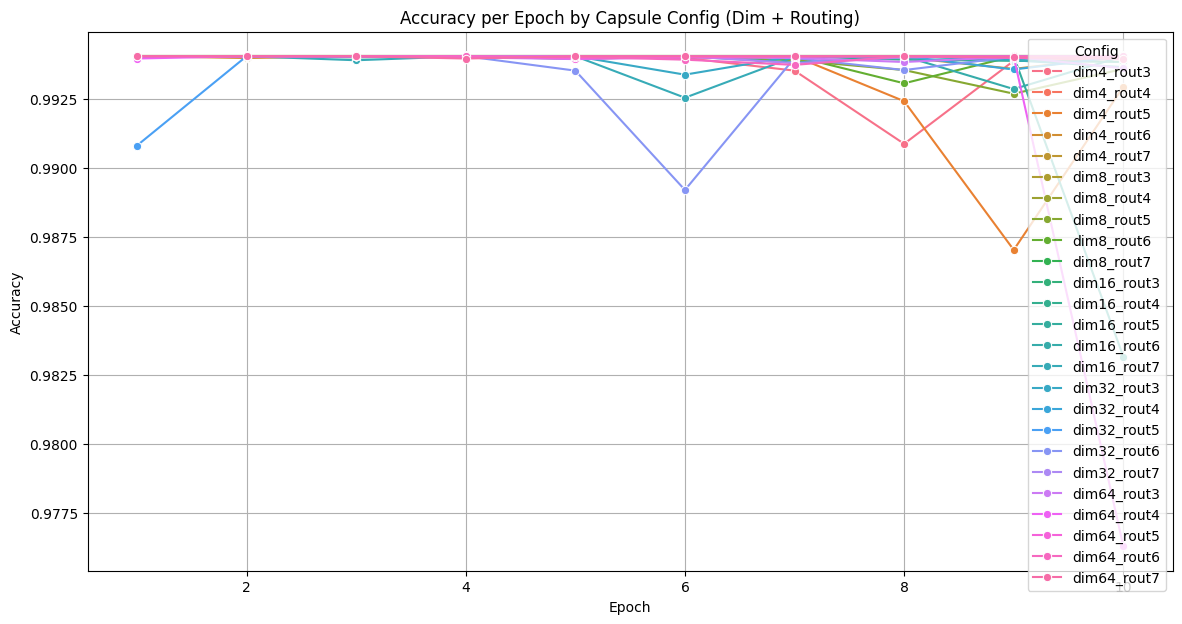

In [ ]:
results_df['Config'] = results_df.apply(lambda row: f'dim{row.Dim}_rout{row.Routings}', axis=1)

plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='Epoch', y='Accuracy', hue='Config', marker='o')
plt.title('Accuracy per Epoch by Capsule Config (Dim + Routing)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Config')
plt.grid(True)
plt.show()


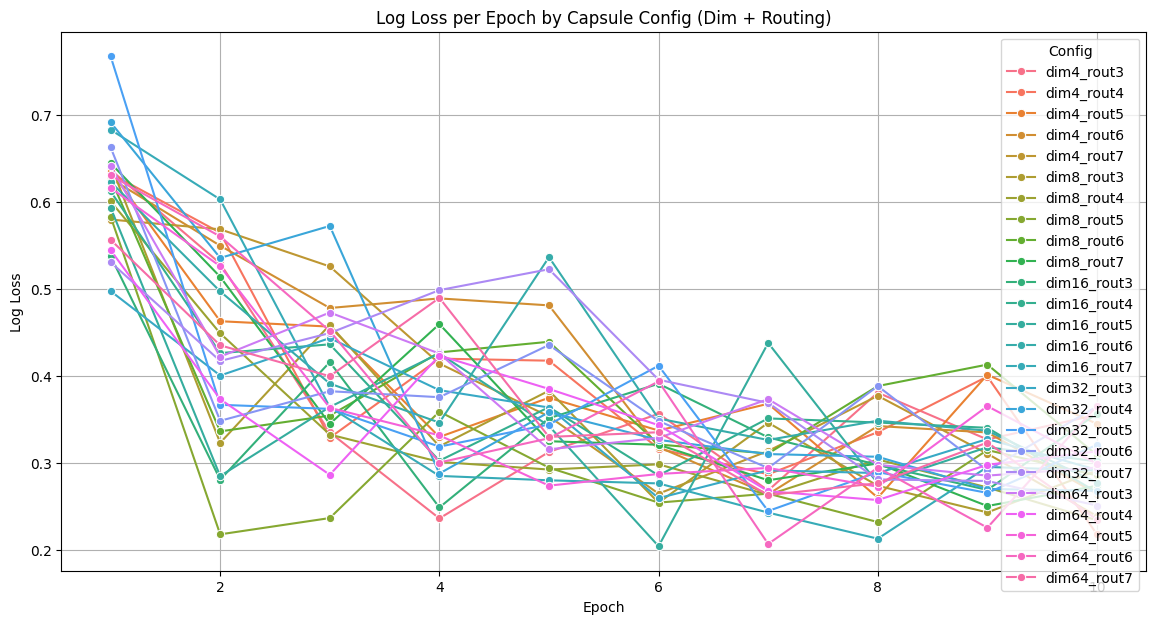

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='Epoch', y='Log Loss', hue='Config', marker='o')
plt.title('Log Loss per Epoch by Capsule Config (Dim + Routing)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend(title='Config')
plt.grid(True)
plt.show()


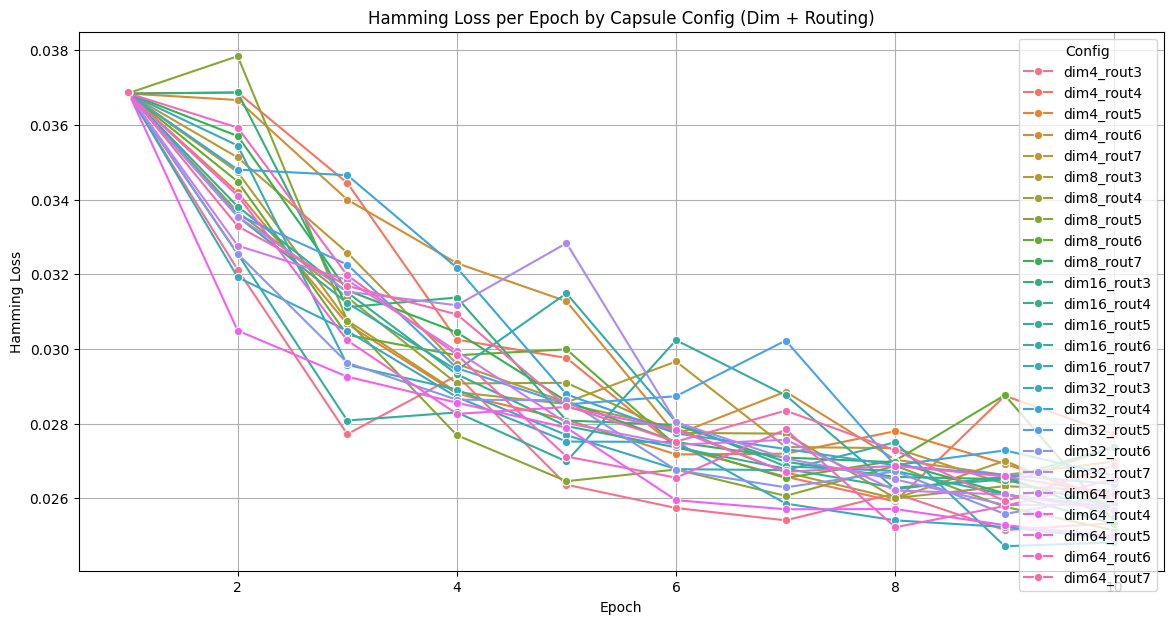

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='Epoch', y='Hamming Loss', hue='Config', marker='o')
plt.title('Hamming Loss per Epoch by Capsule Config (Dim + Routing)')
plt.xlabel('Epoch')
plt.ylabel('Hamming Loss')
plt.legend(title='Config')
plt.grid(True)
plt.show()


In [ ]:
results_df_sorted

,Model,Accuracy,Log Loss,Hamming Loss,Dim,Routing,Epoch
0,model_dim4_routing3_epoch01.h5,0.994047,0.636473,0.036838,4,3,1
1,model_dim4_routing3_epoch02.h5,0.994047,0.529097,0.032120,4,3,2
2,model_dim4_routing3_epoch03.h5,0.994047,0.335222,0.027716,4,3,3
3,model_dim4_routing3_epoch04.h5,0.994047,0.236584,0.029290,4,3,4
4,model_dim4_routing3_epoch05.h5,0.994005,0.312854,0.026362,4,3,5
...,...,...,...,...,...,...,...
245,model_dim64_routing7_epoch06.h5,0.994047,0.335438,0.027518,64,7,6
246,model_dim64_routing7_epoch07.h5,0.994047,0.263329,0.028346,64,7,7
247,model_dim64_routing7_epoch08.h5,0.994047,0.276932,0.027285,64,7,8
248,model_dim64_routing7_epoch09.h5,0.994005,0.323610,0.025923,64,7,9


# Continuing the training to 20 epochs


In [ ]:
embeddings_path = '/content/drive/MyDrive/A/A_forSkripsiii/BERTembeddings200.npy'
embedding_array = np.load(embeddings_path)
data = pd.read_csv('/content/drive/MyDrive/A/A_forSkripsiii/train.csv')
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
X_train, X_val, y_train, y_val = train_test_split(embedding_array, labels, test_size=0.3, random_state=42)

In [ ]:
from keras.models import load_model
from keras.optimizers import Adam
import os

# Custom layers
custom_objects = {'Capsule': Capsule, 'SquashActivation': SquashActivation}

# Directory where models are saved
model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/'

# List of models to continue training
models_to_train = [
    'model_dim32_routing3_epoch10.h5',
    'model_dim8_routing7_epoch10.h5',
    'model_dim16_routing6_epoch10.h5',
    'model_dim8_routing3_epoch10.h5',
    'model_dim32_routing7_epoch10.h5'
]

new_epochs = 20

for model_file in models_to_train:
    print(f"\n=== Continuing training for: {model_file} ===")
    model_path = os.path.join(model_dir, model_file)

    # Load the model
    model = load_model(model_path, custom_objects=custom_objects)

    # Recompile if needed
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Resume training from epoch 10
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=128,
        initial_epoch=10,
        epochs=new_epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(
                    model_dir,
                    model_file.replace('epoch10', 'epoch{epoch:02d}')
                ),
                save_weights_only=False,
                save_best_only=False,
                verbose=1
            )
        ]
    )



=== Continuing training for: model_dim32_routing3_epoch10.h5 ===
Epoch 11/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9944 - loss: 0.0709
Epoch 11: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch11.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 77s 80ms/step - accuracy: 0.9944 - loss: 0.0709 - val_accuracy: 0.9940 - val_loss: 0.0806
Epoch 12/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9942 - loss: 0.0698
Epoch 12: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch12.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9942 - loss: 0.0698 - val_accuracy: 0.9937 - val_loss: 0.0701
Epoch 13/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9942 - loss: 0.0691
Epoch 13: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch13.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9942 - loss: 0.0691 - val_accuracy: 0.9940 - val_loss: 0.0705
Epoch 14/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9931 - loss: 0.0682
Epoch 14: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch14.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9931 - loss: 0.0682 - val_accuracy: 0.9937 - val_loss: 0.0697
Epoch 15/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9921 - loss: 0.0682
Epoch 15: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch15.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9921 - loss: 0.0682 - val_accuracy: 0.9940 - val_loss: 0.0681
Epoch 16/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9939 - loss: 0.0665
Epoch 16: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch16.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9939 - loss: 0.0665 - val_accuracy: 0.9940 - val_loss: 0.0727
Epoch 17/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9932 - loss: 0.0666
Epoch 17: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch17.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9932 - loss: 0.0666 - val_accuracy: 0.9940 - val_loss: 0.0681
Epoch 18/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9922 - loss: 0.0655
Epoch 18: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch18.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9922 - loss: 0.0655 - val_accuracy: 0.9911 - val_loss: 0.0700
Epoch 19/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9910 - loss: 0.0654
Epoch 19: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch19.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9910 - loss: 0.0654 - val_accuracy: 0.9940 - val_loss: 0.0672
Epoch 20/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9934 - loss: 0.0662
Epoch 20: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch20.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9934 - loss: 0.0662 - val_accuracy: 0.9940 - val_loss: 0.0661

=== Continuing training for: model_dim8_routing7_epoch10.h5 ===


Epoch 11/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9927 - loss: 0.0746
Epoch 11: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch11.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 73ms/step - accuracy: 0.9927 - loss: 0.0746 - val_accuracy: 0.9940 - val_loss: 0.0725
Epoch 12/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9923 - loss: 0.0716
Epoch 12: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch12.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9923 - loss: 0.0716 - val_accuracy: 0.9940 - val_loss: 0.0799
Epoch 13/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9908 - loss: 0.0728
Epoch 13: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch13.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9908 - loss: 0.0728 - val_accuracy: 0.9939 - val_loss: 0.0700
Epoch 14/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9918 - loss: 0.0700
Epoch 14: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch14.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9918 - loss: 0.0700 - val_accuracy: 0.9940 - val_loss: 0.0695
Epoch 15/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9909 - loss: 0.0697
Epoch 15: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch15.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9909 - loss: 0.0697 - val_accuracy: 0.9938 - val_loss: 0.0707
Epoch 16/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9914 - loss: 0.0680
Epoch 16: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch16.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9914 - loss: 0.0680 - val_accuracy: 0.9923 - val_loss: 0.0680
Epoch 17/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9871 - loss: 0.0675
Epoch 17: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch17.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9871 - loss: 0.0675 - val_accuracy: 0.9903 - val_loss: 0.0681
Epoch 18/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9901 - loss: 0.0654
Epoch 18: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch18.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9901 - loss: 0.0654 - val_accuracy: 0.9939 - val_loss: 0.0673
Epoch 19/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9879 - loss: 0.0662
Epoch 19: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch19.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9879 - loss: 0.0662 - val_accuracy: 0.9869 - val_loss: 0.0676
Epoch 20/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9899 - loss: 0.0659
Epoch 20: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch20.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step - accuracy: 0.9899 - loss: 0.0659 - val_accuracy: 0.9778 - val_loss: 0.0693

=== Continuing training for: model_dim16_routing6_epoch10.h5 ===


Epoch 11/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9939 - loss: 0.0749
Epoch 11: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch11.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 74s 81ms/step - accuracy: 0.9939 - loss: 0.0749 - val_accuracy: 0.9940 - val_loss: 0.0913
Epoch 12/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9942 - loss: 0.0754
Epoch 12: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch12.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.9942 - loss: 0.0754 - val_accuracy: 0.9939 - val_loss: 0.0788
Epoch 13/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9939 - loss: 0.0727
Epoch 13: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch13.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.9939 - loss: 0.0727 - val_accuracy: 0.9940 - val_loss: 0.0717
Epoch 14/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9942 - loss: 0.0720
Epoch 14: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch14.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.9942 - loss: 0.0720 - val_accuracy: 0.9940 - val_loss: 0.0717
Epoch 15/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9938 - loss: 0.0700
Epoch 15: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch15.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.9938 - loss: 0.0700 - val_accuracy: 0.9940 - val_loss: 0.0701
Epoch 16/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9933 - loss: 0.0694
Epoch 16: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch16.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.9933 - loss: 0.0694 - val_accuracy: 0.9940 - val_loss: 0.0701
Epoch 17/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9932 - loss: 0.0679
Epoch 17: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch17.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.9932 - loss: 0.0679 - val_accuracy: 0.9940 - val_loss: 0.0765
Epoch 18/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9926 - loss: 0.0684
Epoch 18: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch18.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.9926 - loss: 0.0684 - val_accuracy: 0.9939 - val_loss: 0.0690
Epoch 19/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9917 - loss: 0.0669
Epoch 19: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch19.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.9917 - loss: 0.0669 - val_accuracy: 0.9940 - val_loss: 0.0707
Epoch 20/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9928 - loss: 0.0673
Epoch 20: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch20.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.9928 - loss: 0.0673 - val_accuracy: 0.9940 - val_loss: 0.0735

=== Continuing training for: model_dim8_routing3_epoch10.h5 ===


Epoch 11/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9943 - loss: 0.0729
Epoch 11: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch11.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.9943 - loss: 0.0729 - val_accuracy: 0.9940 - val_loss: 0.0735
Epoch 12/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9941 - loss: 0.0729
Epoch 12: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch12.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9941 - loss: 0.0729 - val_accuracy: 0.9939 - val_loss: 0.0750
Epoch 13/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9945 - loss: 0.0696
Epoch 13: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch13.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9945 - loss: 0.0696 - val_accuracy: 0.9940 - val_loss: 0.0707
Epoch 14/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9938 - loss: 0.0704
Epoch 14: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch14.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9938 - loss: 0.0704 - val_accuracy: 0.9940 - val_loss: 0.0704
Epoch 15/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9938 - loss: 0.0705
Epoch 15: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch15.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9938 - loss: 0.0705 - val_accuracy: 0.9940 - val_loss: 0.0700
Epoch 16/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9935 - loss: 0.0689
Epoch 16: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch16.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9935 - loss: 0.0689 - val_accuracy: 0.9940 - val_loss: 0.0684
Epoch 17/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9936 - loss: 0.0681
Epoch 17: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch17.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9936 - loss: 0.0681 - val_accuracy: 0.9939 - val_loss: 0.0720
Epoch 18/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9937 - loss: 0.0676
Epoch 18: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch18.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9937 - loss: 0.0676 - val_accuracy: 0.9939 - val_loss: 0.0681
Epoch 19/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9939 - loss: 0.0667
Epoch 19: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch19.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9939 - loss: 0.0667 - val_accuracy: 0.9938 - val_loss: 0.0693
Epoch 20/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9935 - loss: 0.0672
Epoch 20: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch20.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9935 - loss: 0.0672 - val_accuracy: 0.9940 - val_loss: 0.0677

=== Continuing training for: model_dim32_routing7_epoch10.h5 ===


Epoch 11/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9939 - loss: 0.0740
Epoch 11: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch11.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 93s 102ms/step - accuracy: 0.9939 - loss: 0.0740 - val_accuracy: 0.9940 - val_loss: 0.0771
Epoch 12/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9941 - loss: 0.0728
Epoch 12: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch12.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.9941 - loss: 0.0728 - val_accuracy: 0.9940 - val_loss: 0.0739
Epoch 13/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9943 - loss: 0.0721
Epoch 13: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch13.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.9943 - loss: 0.0721 - val_accuracy: 0.9939 - val_loss: 0.0735
Epoch 14/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9939 - loss: 0.0712
Epoch 14: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch14.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.9939 - loss: 0.0712 - val_accuracy: 0.9940 - val_loss: 0.0703
Epoch 15/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9935 - loss: 0.0702
Epoch 15: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch15.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.9935 - loss: 0.0702 - val_accuracy: 0.9940 - val_loss: 0.0692
Epoch 16/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9939 - loss: 0.0683
Epoch 16: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch16.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.9939 - loss: 0.0683 - val_accuracy: 0.9940 - val_loss: 0.0709
Epoch 17/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9928 - loss: 0.0688
Epoch 17: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch17.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.9928 - loss: 0.0688 - val_accuracy: 0.9921 - val_loss: 0.0698
Epoch 18/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9936 - loss: 0.0686
Epoch 18: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch18.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.9936 - loss: 0.0686 - val_accuracy: 0.9934 - val_loss: 0.0688
Epoch 19/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9930 - loss: 0.0671
Epoch 19: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch19.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.9930 - loss: 0.0671 - val_accuracy: 0.9934 - val_loss: 0.0689
Epoch 20/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9933 - loss: 0.0665
Epoch 20: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch20.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 100ms/step - accuracy: 0.9933 - loss: 0.0665 - val_accuracy: 0.9940 - val_loss: 0.0679


In [ ]:
import os
import re
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.metrics import log_loss, hamming_loss

# Directory with models
model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/'

# List of base model identifiers
target_bases = [
    'model_dim32_routing3',
    'model_dim8_routing7',
    'model_dim16_routing6',
    'model_dim8_routing3',
    'model_dim32_routing7'
]

# Custom layers
custom_objects = {'Capsule': Capsule, 'SquashActivation': SquashActivation}

results = []


In [ ]:

for model_file in os.listdir(model_dir):
    if not model_file.endswith('.h5'):
        continue

    # Check if the file starts with any target base name
    if any(model_file.startswith(base) for base in target_bases):
        model_path = os.path.join(model_dir, model_file)
        print(f"Evaluating {model_file}")

        # Load model
        model = load_model(model_path, custom_objects=custom_objects)

        # Predict
        y_pred_prob = model.predict(X_val, verbose=0)

        # Evaluate
        loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
        hamming = hamming_loss(np.round(y_pred_prob), y_val)
        logloss = log_loss(y_val, y_pred_prob)

        # Extract config info
        match = re.search(r"model_dim(\d+)_routing(\d+)_epoch(\d+)", model_file)
        if match:
            dim = int(match.group(1))
            routing = int(match.group(2))
            epoch = int(match.group(3))
        else:
            continue

        results.append({
            'Model': model_file,
            'Dim': dim,
            'Routing': routing,
            'Epoch': epoch,
            'Accuracy': accuracy,
            'Log Loss': logloss,
            'Hamming Loss': hamming
        })


Evaluating model_dim8_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch06.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch07.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch08.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch09.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch10.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch11.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch12.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch13.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch14.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch15.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch16.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch17.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch18.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch19.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch20.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch11.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch12.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch13.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch14.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch15.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch16.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch17.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch18.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch19.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch20.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch11.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch12.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch13.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch14.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch15.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch16.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch17.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch18.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch19.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch20.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch11.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch12.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch13.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch14.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch15.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch16.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch17.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch18.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch19.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch20.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch11.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch12.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch13.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch14.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch15.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch16.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch17.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch18.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch19.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch20.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:

# Convert to DataFrame
results_df_new = pd.DataFrame(results)

# Sort
results_df_sorted = results_df_new.sort_values(by=['Dim', 'Routing', 'Epoch']).reset_index(drop=True)
print(results_df_sorted)


In [ ]:
results_df_sorted

,Model,Dim,Routing,Epoch,Accuracy,Log Loss,Hamming Loss,Config
0,model_dim8_routing3_epoch01.h5,8,3,1,0.994047,0.642442,0.036838,dim8_rout3
1,model_dim8_routing3_epoch02.h5,8,3,2,0.994047,0.323311,0.034732,dim8_rout3
2,model_dim8_routing3_epoch03.h5,8,3,3,0.994047,0.458626,0.030759,dim8_rout3
3,model_dim8_routing3_epoch04.h5,8,3,4,0.994047,0.319252,0.028841,dim8_rout3
4,model_dim8_routing3_epoch05.h5,8,3,5,0.994047,0.383106,0.028524,dim8_rout3
...,...,...,...,...,...,...,...,...
95,model_dim32_routing7_epoch16.h5,32,7,16,0.994005,0.220091,0.025039,dim32_rout7
96,model_dim32_routing7_epoch17.h5,32,7,17,0.992125,0.307921,0.024426,dim32_rout7
97,model_dim32_routing7_epoch18.h5,32,7,18,0.993420,0.267282,0.024176,dim32_rout7
98,model_dim32_routing7_epoch19.h5,32,7,19,0.993441,0.239969,0.024426,dim32_rout7


In [ ]:
import openpyxl
results_df_sorted.to_excel('/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/selected_models_eval.xlsx', index=False)


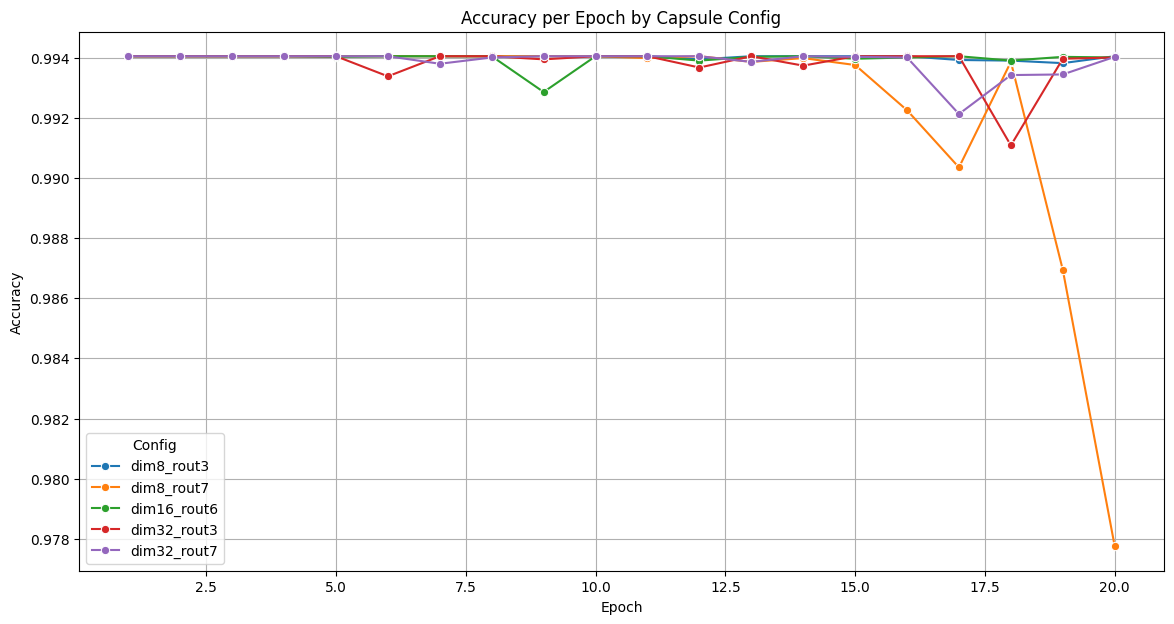

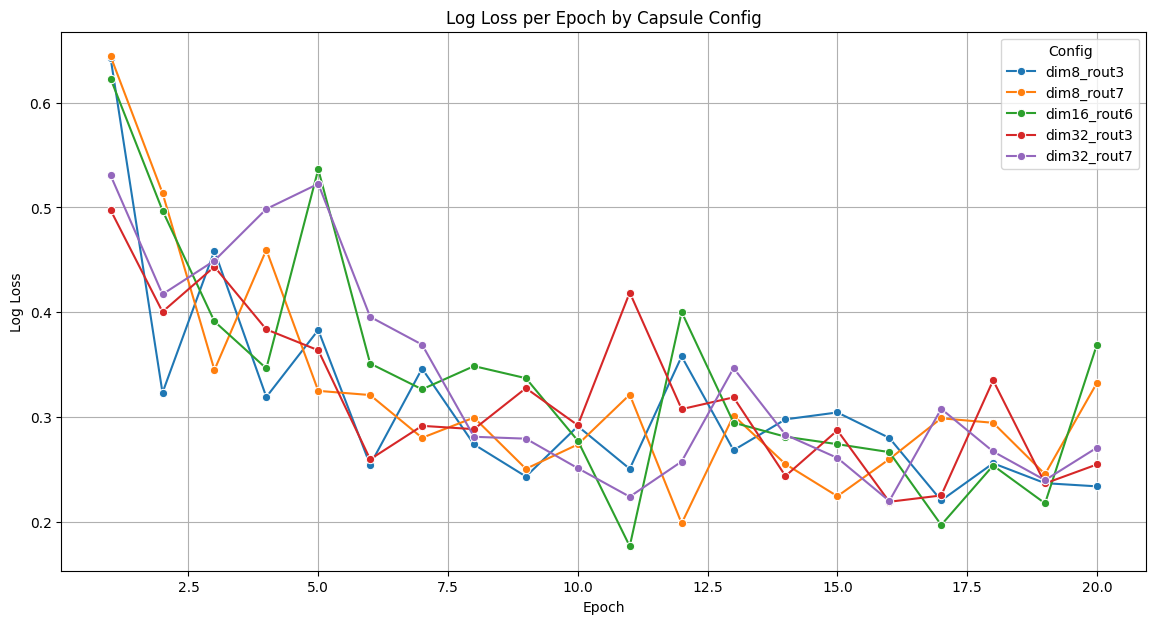

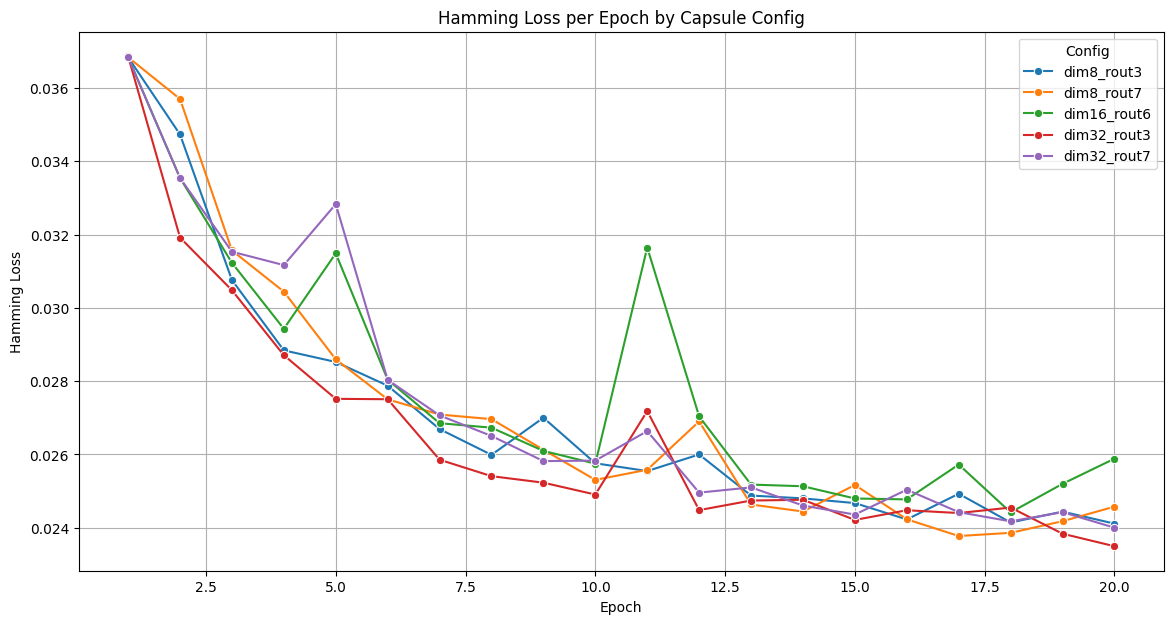

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

results_df_sorted['Config'] = results_df_sorted.apply(lambda row: f'dim{row.Dim}_rout{row.Routing}', axis=1)

# Accuracy plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df_sorted, x='Epoch', y='Accuracy', hue='Config', marker='o')
plt.title('Accuracy per Epoch by Capsule Config')
plt.grid(True)
plt.show()

# Log Loss plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df_sorted, x='Epoch', y='Log Loss', hue='Config', marker='o')
plt.title('Log Loss per Epoch by Capsule Config')
plt.grid(True)
plt.show()

# Hamming Loss plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df_sorted, x='Epoch', y='Hamming Loss', hue='Config', marker='o')
plt.title('Hamming Loss per Epoch by Capsule Config')
plt.grid(True)
plt.show()


# Continuing the training to 30 epochs


In [ ]:
embeddings_path = '/content/drive/MyDrive/A/A_forSkripsiii/BERTembeddings200.npy'
embedding_array = np.load(embeddings_path)
data = pd.read_csv('/content/drive/MyDrive/A/A_forSkripsiii/train.csv')
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
X_train, X_val, y_train, y_val = train_test_split(embedding_array, labels, test_size=0.3, random_state=42)

In [ ]:
from keras.models import load_model
from keras.optimizers import Adam
import os

# Custom layers
custom_objects = {'Capsule': Capsule, 'SquashActivation': SquashActivation}

# Directory where models are saved
model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/'

# List of models to continue training
models_to_train = [
    'model_dim32_routing3_epoch20.h5',
    'model_dim8_routing7_epoch20.h5',
    'model_dim16_routing6_epoch20.h5',
    'model_dim8_routing3_epoch20.h5',
    'model_dim32_routing7_epoch20.h5'
]

new_epochs = 30

for model_file in models_to_train:
    print(f"\n=== Continuing training for: {model_file} ===")
    model_path = os.path.join(model_dir, model_file)

    # Load the model
    model = load_model(model_path, custom_objects=custom_objects)

    # Recompile if needed
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Resume training from epoch 20
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=128,
        initial_epoch=20,
        epochs=new_epochs,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(
                    model_dir,
                    model_file.replace('epoch20', 'epoch{epoch:02d}')
                ),
                save_weights_only=False,
                save_best_only=False,
                verbose=1
            )
        ]
    )



=== Continuing training for: model_dim32_routing3_epoch20.h5 ===
Epoch 21/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9913 - loss: 0.0646
Epoch 21: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch21.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.9913 - loss: 0.0646 - val_accuracy: 0.9861 - val_loss: 0.0668
Epoch 22/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9876 - loss: 0.0647
Epoch 22: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch22.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9876 - loss: 0.0647 - val_accuracy: 0.9852 - val_loss: 0.0657
Epoch 23/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9872 - loss: 0.0645
Epoch 23: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch23.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.9872 - loss: 0.0645 - val_accuracy: 0.9924 - val_loss: 0.0655
Epoch 24/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9870 - loss: 0.0639
Epoch 24: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch24.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9870 - loss: 0.0639 - val_accuracy: 0.9939 - val_loss: 0.0649
Epoch 25/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9906 - loss: 0.0627
Epoch 25: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch25.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.9906 - loss: 0.0627 - val_accuracy: 0.9938 - val_loss: 0.0656
Epoch 26/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9890 - loss: 0.0618
Epoch 26: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch26.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.9890 - loss: 0.0618 - val_accuracy: 0.9855 - val_loss: 0.0649
Epoch 27/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9849 - loss: 0.0626
Epoch 27: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch27.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9849 - loss: 0.0626 - val_accuracy: 0.9933 - val_loss: 0.0652
Epoch 28/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9859 - loss: 0.0624
Epoch 28: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch28.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.9859 - loss: 0.0624 - val_accuracy: 0.9390 - val_loss: 0.0701
Epoch 29/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9827 - loss: 0.0612
Epoch 29: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch29.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.9827 - loss: 0.0612 - val_accuracy: 0.9923 - val_loss: 0.0645
Epoch 30/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9803 - loss: 0.0615
Epoch 30: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing3_epoch30.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.9803 - loss: 0.0615 - val_accuracy: 0.9825 - val_loss: 0.0656

=== Continuing training for: model_dim8_routing7_epoch20.h5 ===


Epoch 21/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9869 - loss: 0.0646
Epoch 21: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch21.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 74ms/step - accuracy: 0.9869 - loss: 0.0646 - val_accuracy: 0.9938 - val_loss: 0.0663
Epoch 22/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9899 - loss: 0.0634
Epoch 22: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch22.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9899 - loss: 0.0634 - val_accuracy: 0.9922 - val_loss: 0.0648
Epoch 23/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9847 - loss: 0.0635
Epoch 23: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch23.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9847 - loss: 0.0635 - val_accuracy: 0.9907 - val_loss: 0.0654
Epoch 24/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9871 - loss: 0.0634
Epoch 24: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch24.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9871 - loss: 0.0634 - val_accuracy: 0.9834 - val_loss: 0.0645
Epoch 25/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9825 - loss: 0.0629
Epoch 25: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch25.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9825 - loss: 0.0629 - val_accuracy: 0.9890 - val_loss: 0.0648
Epoch 26/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9815 - loss: 0.0621
Epoch 26: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch26.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9815 - loss: 0.0621 - val_accuracy: 0.9885 - val_loss: 0.0639
Epoch 27/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9747 - loss: 0.0618
Epoch 27: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch27.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9747 - loss: 0.0618 - val_accuracy: 0.9931 - val_loss: 0.0647
Epoch 28/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9819 - loss: 0.0614
Epoch 28: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch28.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9819 - loss: 0.0614 - val_accuracy: 0.9900 - val_loss: 0.0652
Epoch 29/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9738 - loss: 0.0623
Epoch 29: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch29.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9738 - loss: 0.0623 - val_accuracy: 0.9855 - val_loss: 0.0690
Epoch 30/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9756 - loss: 0.0609
Epoch 30: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing7_epoch30.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step - accuracy: 0.9756 - loss: 0.0609 - val_accuracy: 0.9703 - val_loss: 0.0643

=== Continuing training for: model_dim16_routing6_epoch20.h5 ===


Epoch 21/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9905 - loss: 0.0665
Epoch 21: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch21.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 75s 81ms/step - accuracy: 0.9905 - loss: 0.0665 - val_accuracy: 0.9940 - val_loss: 0.0697
Epoch 22/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9910 - loss: 0.0659
Epoch 22: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch22.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9910 - loss: 0.0659 - val_accuracy: 0.9889 - val_loss: 0.0670
Epoch 23/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9920 - loss: 0.0656
Epoch 23: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch23.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9920 - loss: 0.0656 - val_accuracy: 0.9898 - val_loss: 0.0678
Epoch 24/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9916 - loss: 0.0648
Epoch 24: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch24.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9916 - loss: 0.0648 - val_accuracy: 0.9761 - val_loss: 0.0699
Epoch 25/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9908 - loss: 0.0640
Epoch 25: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch25.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9908 - loss: 0.0640 - val_accuracy: 0.9940 - val_loss: 0.0699
Epoch 26/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9893 - loss: 0.0645
Epoch 26: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch26.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9893 - loss: 0.0645 - val_accuracy: 0.9929 - val_loss: 0.0665
Epoch 27/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9886 - loss: 0.0631
Epoch 27: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch27.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9886 - loss: 0.0631 - val_accuracy: 0.9936 - val_loss: 0.0675
Epoch 28/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9888 - loss: 0.0647
Epoch 28: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch28.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9888 - loss: 0.0647 - val_accuracy: 0.9837 - val_loss: 0.0651
Epoch 29/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9853 - loss: 0.0629
Epoch 29: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch29.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9853 - loss: 0.0629 - val_accuracy: 0.9939 - val_loss: 0.0669
Epoch 30/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9818 - loss: 0.0630
Epoch 30: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim16_routing6_epoch30.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.9818 - loss: 0.0630 - val_accuracy: 0.9913 - val_loss: 0.0646

=== Continuing training for: model_dim8_routing3_epoch20.h5 ===


Epoch 21/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9939 - loss: 0.0653
Epoch 21: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch21.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.9939 - loss: 0.0653 - val_accuracy: 0.9918 - val_loss: 0.0676
Epoch 22/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9926 - loss: 0.0666
Epoch 22: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch22.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9926 - loss: 0.0666 - val_accuracy: 0.9939 - val_loss: 0.0724
Epoch 23/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9933 - loss: 0.0675
Epoch 23: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch23.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9933 - loss: 0.0675 - val_accuracy: 0.9940 - val_loss: 0.0673
Epoch 24/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9936 - loss: 0.0654
Epoch 24: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch24.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9936 - loss: 0.0654 - val_accuracy: 0.9882 - val_loss: 0.0701
Epoch 25/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9934 - loss: 0.0638
Epoch 25: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch25.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9934 - loss: 0.0638 - val_accuracy: 0.9940 - val_loss: 0.0661
Epoch 26/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9930 - loss: 0.0640
Epoch 26: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch26.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9930 - loss: 0.0640 - val_accuracy: 0.9940 - val_loss: 0.0659
Epoch 27/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9934 - loss: 0.0638
Epoch 27: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch27.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9934 - loss: 0.0638 - val_accuracy: 0.9940 - val_loss: 0.0661
Epoch 28/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9939 - loss: 0.0634
Epoch 28: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch28.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9939 - loss: 0.0634 - val_accuracy: 0.9937 - val_loss: 0.0661
Epoch 29/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9929 - loss: 0.0626
Epoch 29: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch29.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9929 - loss: 0.0626 - val_accuracy: 0.9940 - val_loss: 0.0647
Epoch 30/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9926 - loss: 0.0621
Epoch 30: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim8_routing3_epoch30.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.9926 - loss: 0.0621 - val_accuracy: 0.9940 - val_loss: 0.0651

=== Continuing training for: model_dim32_routing7_epoch20.h5 ===


Epoch 21/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9927 - loss: 0.0665
Epoch 21: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch21.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 94s 102ms/step - accuracy: 0.9927 - loss: 0.0665 - val_accuracy: 0.9907 - val_loss: 0.0668
Epoch 22/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9925 - loss: 0.0641
Epoch 22: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch22.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.9925 - loss: 0.0641 - val_accuracy: 0.9939 - val_loss: 0.0668
Epoch 23/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9907 - loss: 0.0651
Epoch 23: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch23.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.9907 - loss: 0.0651 - val_accuracy: 0.9940 - val_loss: 0.0689
Epoch 24/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9910 - loss: 0.0650
Epoch 24: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch24.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.9910 - loss: 0.0650 - val_accuracy: 0.9921 - val_loss: 0.0661
Epoch 25/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9907 - loss: 0.0639
Epoch 25: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch25.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.9907 - loss: 0.0639 - val_accuracy: 0.9940 - val_loss: 0.0674
Epoch 26/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9904 - loss: 0.0629
Epoch 26: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch26.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.9904 - loss: 0.0629 - val_accuracy: 0.9931 - val_loss: 0.0702
Epoch 27/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9897 - loss: 0.0633
Epoch 27: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch27.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.9897 - loss: 0.0633 - val_accuracy: 0.9939 - val_loss: 0.0651
Epoch 28/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9889 - loss: 0.0626
Epoch 28: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch28.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.9889 - loss: 0.0626 - val_accuracy: 0.9929 - val_loss: 0.0648
Epoch 29/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9879 - loss: 0.0637
Epoch 29: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch29.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.9879 - loss: 0.0637 - val_accuracy: 0.9931 - val_loss: 0.0646
Epoch 30/30
873/873 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9785 - loss: 0.0601
Epoch 30: saving model to /content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/model_dim32_routing7_epoch30.h5


873/873 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.9785 - loss: 0.0601 - val_accuracy: 0.9722 - val_loss: 0.0639


In [ ]:
import os
import re
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.metrics import log_loss, hamming_loss

# Directory with models
model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/'

# List of base model identifiers
target_bases = [
    'model_dim32_routing3',
    'model_dim8_routing7',
    'model_dim16_routing6',
    'model_dim8_routing3',
    'model_dim32_routing7'
]

# Custom layers
custom_objects = {'Capsule': Capsule, 'SquashActivation': SquashActivation}

results = []


In [ ]:
for model_file in os.listdir(model_dir):
    if not model_file.endswith('.h5'):
        continue

    # Check if the file starts with any target base name
    if any(model_file.startswith(base) for base in target_bases):
        match = re.search(r"model_dim(\d+)_routing(\d+)_epoch(\d+)", model_file)
        if match:
            epoch = int(match.group(3))
            if epoch <= 20 or epoch > 30:
                continue  # Skip models outside 20–30
        else:
            continue

        model_path = os.path.join(model_dir, model_file)
        print(f"Evaluating {model_file}")

        # Load model
        model = load_model(model_path, custom_objects=custom_objects)

        # Predict
        y_pred_prob = model.predict(X_val, verbose=0)

        # Evaluate
        loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
        hamming = hamming_loss(np.round(y_pred_prob), y_val)
        logloss = log_loss(y_val, y_pred_prob)

        dim = int(match.group(1))
        routing = int(match.group(2))

        results.append({
            'Model': model_file,
            'Dim': dim,
            'Routing': routing,
            'Epoch': epoch,
            'Accuracy': accuracy,
            'Log Loss': logloss,
            'Hamming Loss': hamming
        })

# Convert to DataFrame
results_df_20_30 = pd.DataFrame(results).sort_values(by=['Dim', 'Routing', 'Epoch']).reset_index(drop=True)


Evaluating model_dim32_routing3_epoch21.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch22.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch23.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch24.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch25.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch26.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch27.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch28.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch29.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing3_epoch30.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch21.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch22.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch23.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch24.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch25.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch26.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch27.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch28.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch29.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing7_epoch30.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch21.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch22.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch23.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch24.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch25.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch26.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch27.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch28.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch29.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim16_routing6_epoch30.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch21.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch22.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch23.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch24.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch25.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch26.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch27.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch28.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch29.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim8_routing3_epoch30.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch21.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch22.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch23.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch24.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch25.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch26.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch27.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch28.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch29.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model_dim32_routing7_epoch30.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
results_df_20_30.to_excel('/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/selected_models_eval_20_30.xlsx', index=False)

In [ ]:
import pandas as pd

# Epochs 0–20
df_0_20 = pd.read_excel('/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/selected_models_eval.xlsx')

# Epochs 20–30
df_20_30 = pd.read_excel('/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/selected_models_eval_20_30.xlsx')


In [ ]:
df_0_20see = df_0_20[
    df_0_20['Epoch'] == 20
]

In [ ]:
df_0_20see

,Model,Dim,Routing,Epoch,Accuracy,Log Loss,Hamming Loss,Config
19,model_dim8_routing3_epoch20.h5,8,3,20,0.994047,0.234057,0.024113,dim8_rout3
39,model_dim8_routing7_epoch20.h5,8,7,20,0.977753,0.332713,0.024576,dim8_rout7
59,model_dim16_routing6_epoch20.h5,16,6,20,0.994005,0.369274,0.025885,dim16_rout6
79,model_dim32_routing3_epoch20.h5,32,3,20,0.994005,0.254933,0.023497,dim32_rout3
99,model_dim32_routing7_epoch20.h5,32,7,20,0.994026,0.270969,0.024002,dim32_rout7


In [ ]:
# Combine into one full epoch range
results_combined = pd.concat([df_0_20, df_20_30], ignore_index=True)

# Sort for plotting consistency
results_combined = results_combined.sort_values(by=['Dim', 'Routing', 'Epoch']).reset_index(drop=True)


In [ ]:
results_combined['Config'] = results_combined.apply(lambda row: f'dim{row.Dim}_rout{row.Routing}', axis=1)


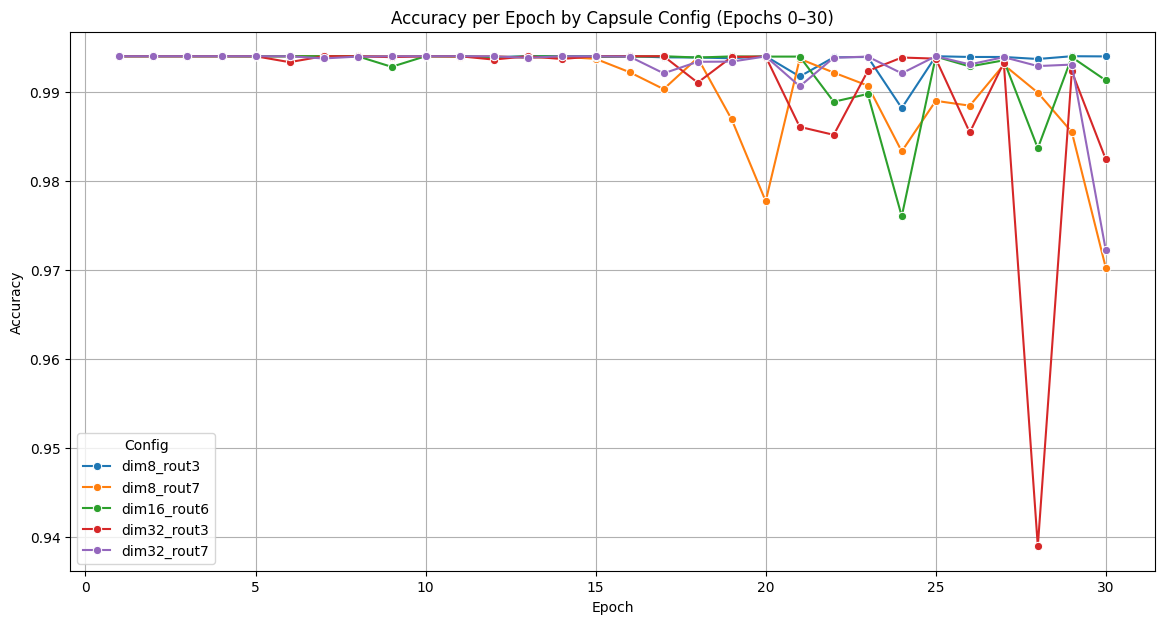

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_combined, x='Epoch', y='Accuracy', hue='Config', marker='o')
plt.title('Accuracy per Epoch by Capsule Config (Epochs 0–30)')
plt.grid(True)
plt.show()

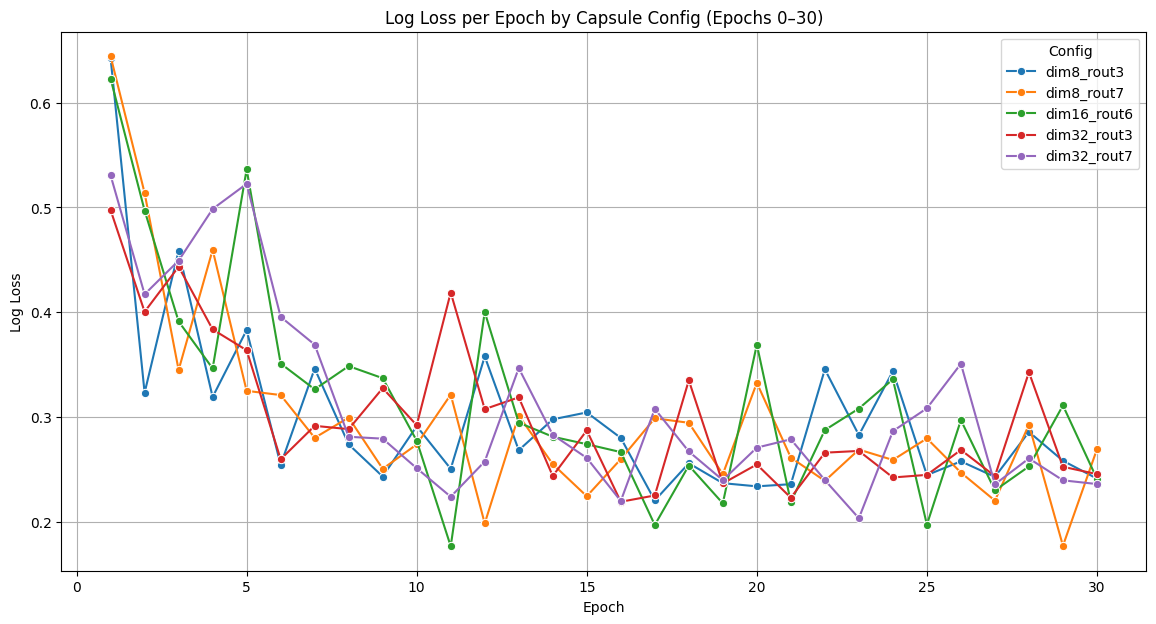

In [ ]:
# Log Loss
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_combined, x='Epoch', y='Log Loss', hue='Config', marker='o')
plt.title('Log Loss per Epoch by Capsule Config (Epochs 0–30)')
plt.grid(True)
plt.show()

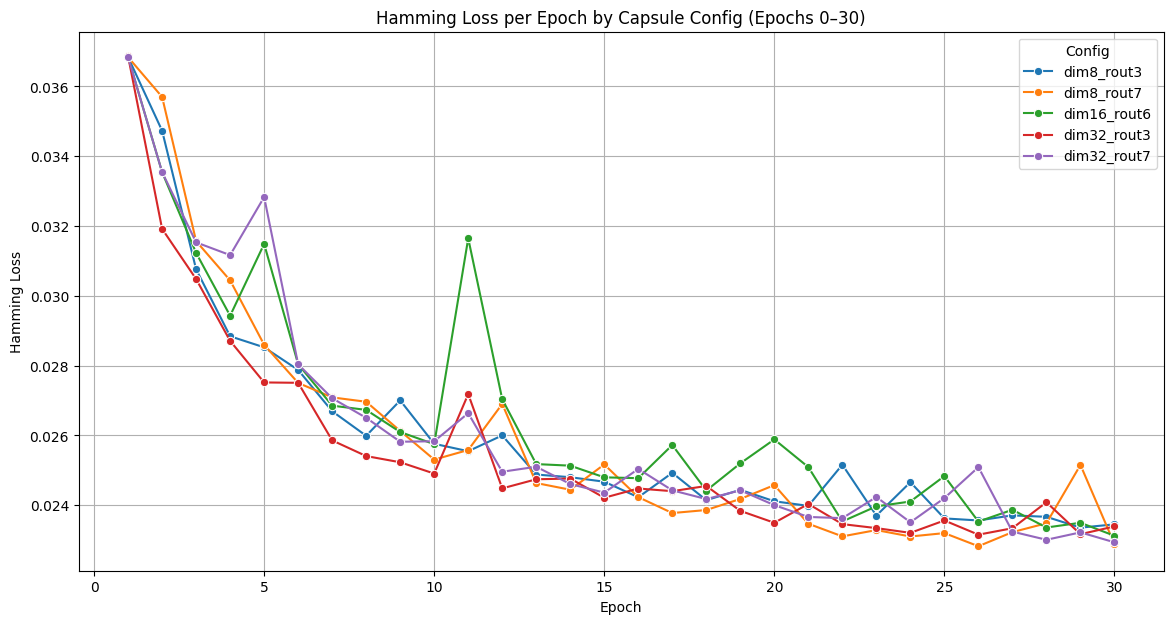

In [ ]:
# Hamming Loss
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_combined, x='Epoch', y='Hamming Loss', hue='Config', marker='o')
plt.title('Hamming Loss per Epoch by Capsule Config (Epochs 0–30)')
plt.grid(True)
plt.show()

In [ ]:
import openpyxl
results_combined.to_excel('/content/drive/MyDrive/A/A_forSkripsiii/BertBigruCN/selected_models_eval_0_30.xlsx', index=False)
